# WOA7015 Medical Visual Question Answering (Med-VQA)
## Group 8 Final Report - Technical Implementation Summary
## Lau Wen Jun & Lim Yun Hui
---

### 1. INTRODUCTION
**Research Question:** Can domain-specific Vision-Language Models (BiomedCLIP) outperform traditional CNN-Transformer architectures for Medical VQA while maintaining clinical reliability?

**Key Contributions:**
- Comparative study of CNN-Transformer baseline vs BiomedCLIP-based VLM
- Temperature-calibrated ensemble combining both architectures
- Clinically-focused error analysis with impact categorization
- Flexible accuracy metrics for fair open-ended evaluation

---

### 2. METHOD

#### 2.1 Dataset Configuration
- **Dataset:** SLAKE (642 images, 14,028 QA pairs)
- **Split:** Train 9,835 / Val 2,099 / Test 1,061
- **Data Leakage Prevention:** Answer vocabulary built from TRAINING only
- **English Filtering:** Applied consistently across all splits

#### 2.2 Model Architectures
| Component | Baseline (CNN-Transformer) | VLM (BiomedCLIP) |
|-----------|---------------------------|------------------|
| Image Encoder | ResNet-50 (ImageNet) | ViT-B/16 (PMC-15M) |
| Text Encoder | Transformer (2 layers) | PubMedBERT |
| Fusion | Cross-attention | Multimodal projection |
| Parameters | 182.6M trainable | 149.7M trainable |

#### 2.3 Training Configuration
- **Loss:** ClinicallyAwareLoss (subset discount + clinical penalty)
- **Optimizer:** AdamW with cosine annealing
- **Augmentation:** Medical-safe transforms (no hue modification)
- **Regularization:** Mixup (VLM), Dropout, Label smoothing

#### 2.4 Ensemble Strategy
- **Calibration:** Temperature scaling (T_bl, T_vlm tuned on validation)
- **Fusion:** Weighted probability averaging (α tuned on validation)
- **Verification:** Sample alignment checked before combining

#### 2.5 Evaluation Framework
- **Flexible Matching:** Stop-word removal, order-independent comparison
- **Metrics:** Strict/Flexible accuracy, BLEU, ROUGE, BERTScore
- **Clinical Analysis:** Error categorization by impact level

---

### 3. RESULTS

#### 3.1 Overall Performance
| Model | Strict Acc | Flexible Acc | True Error Rate |
|-------|-----------|--------------|-----------------|
| Baseline | 81.53% | 83.41% | 16.59% |
| VLM | 84.26% | 86.15% | 13.85% |
| Ensemble | 84.07% | 85.96% | 14.04% |

#### 3.2 Key Findings
- **VLM Advantage:** +2.74% flexible accuracy over baseline
- **Parameter Efficiency:** VLM uses 18% fewer trainable parameters
- **Content-Type Patterns:** VLM excels at shape (+28.6%), color (+11.8%), quantity (+11.5%)
- **Baseline Strength:** Marginally better at organ identification (−2.4%)

#### 3.3 Clinical Error Analysis
- **High-Impact Errors:** 39.5% of VLM errors carry clinical risk
  - Laterality confusion: 18.4%
  - Organ misidentification: 16.3%
  - Condition assessment: 4.8%

#### 3.4 Ensemble Insights
- Temperature calibration improved validation accuracy (86.23%)
- Failed to generalize to test (85.96%) due to correlated error patterns
- Models share failure modes on intrinsically difficult samples

---

### Implementation Features

**Data Integrity:**
✅ No test data leakage in vocabulary/class weights
✅ Validation-based hyperparameter tuning
✅ Consistent preprocessing across splits

**Evaluation Rigor:**
✅ Dual accuracy reporting (strict + flexible)
✅ Question-type stratified analysis
✅ Clinical impact categorization

**Reproducibility:**
✅ All code in GitHub repository
✅ Model checkpoints saved
✅ Results exported to Excel/JSON

## 1. Setup and Installation

In [3]:
# Install required packages
!pip install -q datasets transformers torch torchvision
!pip install -q open_clip_torch timm
!pip install -q scikit-learn matplotlib seaborn
!pip install -q tqdm pandas pillow
!pip install -q scipy statsmodels
!pip install -q bert-score rouge-score sentence-transformers
!pip install -q openpyxl

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os

# ==================== CONFIGURE YOUR PATHS HERE ====================
IMAGE_DIR = "/content/drive/MyDrive/Slake1.0/imgs"  # SLAKE images
SAVE_DIR = "/content/drive/MyDrive/7015_final"   # Save folder
# ===================================================================

os.makedirs(SAVE_DIR, exist_ok=True)

# Verify image path
if os.path.exists(IMAGE_DIR):
    print(f"✓ Image directory found: {IMAGE_DIR}")
else:
    print(f"✗ Image directory NOT found: {IMAGE_DIR}")
    print("  Please check your Google Drive path!")

Mounted at /content/drive
✓ Image directory found: /content/drive/MyDrive/Slake1.0/imgs


In [5]:
# Import libraries
import os
import pickle
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter, ImageEnhance
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torchvision.models as models

# Hugging Face
from datasets import load_dataset
from transformers import BertTokenizer

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from collections import Counter

# LR Scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

# Scipy for temperature scaling
from scipy.optimize import minimize_scalar

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

Using device: cuda


In [6]:
# ==================== DEFINE ALL FILE PATHS ====================
VERSION = '3'

# Model checkpoints
BASELINE_MODEL_PATH = os.path.join(SAVE_DIR, f'baseline_best_{VERSION}.pth')
VLM_MODEL_PATH = os.path.join(SAVE_DIR, f'vlm_best_{VERSION}.pth')

# Training histories
BASELINE_HISTORY_PATH = os.path.join(SAVE_DIR, f'baseline_history_{VERSION}.pkl')
VLM_HISTORY_PATH = os.path.join(SAVE_DIR, f'vlm_history_{VERSION}.pkl')

# Results
RESULTS_PATH = os.path.join(SAVE_DIR, f'results_{VERSION}.json')
TRAINING_CURVES_PATH = os.path.join(SAVE_DIR, f'training_curves_{VERSION}.png')
METRICS_EXCEL_PATH = os.path.join(SAVE_DIR, f'all_metrics_{VERSION}.xlsx')

# Hyperparameters
NUM_EPOCHS = 30
WARMUP_EPOCHS = 5
PATIENCE = 10
BATCH_SIZE = 32

# Mixup settings
MIXUP_ALPHA = 0.2
MIXUP_PROB = 0.3

# Label smoothing
LABEL_SMOOTHING_BASELINE = 0.12
LABEL_SMOOTHING_VLM = 0.122

# Clinical loss settings
SUBSET_DISCOUNT = 0.1       # 90% reduction for subset matches
CLINICAL_PENALTY = 1.3     # 30% increase for medical-critical errors

print("File paths configured:")
print(f"  Save directory: {SAVE_DIR}")
print(f"  Baseline model: {BASELINE_MODEL_PATH}")
print(f"  VLM model: {VLM_MODEL_PATH}")
print(f"\nHyperparameters:")
print(f"  Epochs: {NUM_EPOCHS}, Warmup: {WARMUP_EPOCHS}, Patience: {PATIENCE}")
print(f"  Mixup: alpha={MIXUP_ALPHA}, prob={MIXUP_PROB}")
print(f"  Subset discount: {SUBSET_DISCOUNT}, Clinical penalty: {CLINICAL_PENALTY}")

File paths configured:
  Save directory: /content/drive/MyDrive/7015_final
  Baseline model: /content/drive/MyDrive/7015_final/baseline_best_3.pth
  VLM model: /content/drive/MyDrive/7015_final/vlm_best_3.pth

Hyperparameters:
  Epochs: 30, Warmup: 5, Patience: 10
  Mixup: alpha=0.2, prob=0.3
  Subset discount: 0.1, Clinical penalty: 1.3


## 2. Load Dataset and Filter English

In [7]:
print("Loading SLAKE dataset metadata...")
ds = load_dataset("BoKelvin/SLAKE")
print(f"Dataset loaded successfully!")
print(ds)

Loading SLAKE dataset metadata...


README.md:   0%|          | 0.00/568 [00:00<?, ?B/s]

train.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9835 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2099 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2094 [00:00<?, ? examples/s]

Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['img_name', 'location', 'answer', 'modality', 'base_type', 'answer_type', 'question', 'qid', 'content_type', 'triple', 'img_id', 'q_lang'],
        num_rows: 9835
    })
    validation: Dataset({
        features: ['img_name', 'location', 'answer', 'modality', 'base_type', 'answer_type', 'question', 'qid', 'content_type', 'triple', 'img_id', 'q_lang'],
        num_rows: 2099
    })
    test: Dataset({
        features: ['img_name', 'location', 'answer', 'modality', 'base_type', 'answer_type', 'question', 'qid', 'content_type', 'triple', 'img_id', 'q_lang'],
        num_rows: 2094
    })
})


In [8]:
# ==================== FIX #1: CONSISTENT ENGLISH FILTERING ====================
# Filter English questions ONCE and use filtered data EVERYWHERE

def filter_english(dataset):
    """Filter to English questions only"""
    return [dict(item) for item in dataset if item.get('q_lang', 'en') == 'en']

# Create filtered datasets - USE THESE EVERYWHERE!
train_data = filter_english(ds['train'])
val_data = filter_english(ds['validation'])
test_data = filter_english(ds['test'])

print(f"\n{'='*60}")
print("ENGLISH FILTERING APPLIED (CONSISTENT)")
print(f"{'='*60}")
print(f"Train: {len(ds['train'])} → {len(train_data)} English samples")
print(f"Val:   {len(ds['validation'])} → {len(val_data)} English samples")
print(f"Test:  {len(ds['test'])} → {len(test_data)} English samples")
print(f"\n✓ These filtered lists will be used for ALL datasets")


ENGLISH FILTERING APPLIED (CONSISTENT)
Train: 9835 → 4919 English samples
Val:   2099 → 1053 English samples
Test:  2094 → 1061 English samples

✓ These filtered lists will be used for ALL datasets


## 3. Data Exploration and Analysis

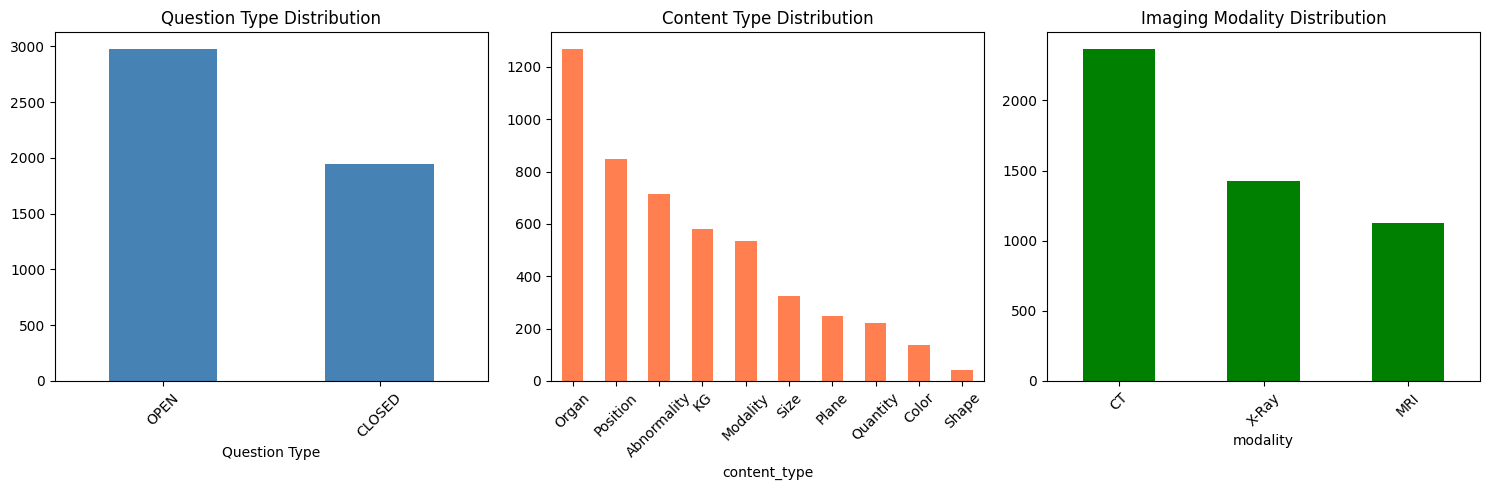

In [9]:
# Data exploration
train_df = pd.DataFrame(train_data)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Question types distribution
if 'answer_type' in train_df.columns:
    train_df['answer_type'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_title('Question Type Distribution')
    axes[0].set_xlabel('Question Type')
    axes[0].tick_params(axis='x', rotation=45)

# Content type distribution
if 'content_type' in train_df.columns:
    train_df['content_type'].value_counts().head(10).plot(kind='bar', ax=axes[1], color='coral')
    axes[1].set_title('Content Type Distribution')
    axes[1].tick_params(axis='x', rotation=45)

# Modality distribution
if 'modality' in train_df.columns:
    train_df['modality'].value_counts().plot(kind='bar', ax=axes[2], color='green')
    axes[2].set_title('Imaging Modality Distribution')
    axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [10]:
# Analyze answer distribution and medical terms
print("=== Answer Statistics ===")
answer_counts_raw = train_df['answer'].value_counts()
print(f"Total unique answers: {len(answer_counts_raw)}")
print(f"\nTop 20 most common answers:")
print(answer_counts_raw.head(20))

# Closed vs Open-ended questions
if 'answer_type' in train_df.columns:
    print(f"\n=== Closed vs Open-ended ===")
    print(train_df['answer_type'].value_counts())

# Analyze medical-critical terms in training data
MEDICAL_CRITICAL = {'left', 'right', 'liver', 'kidney', 'lung', 'heart', 'brain', 'tumor', 'fracture'}
critical_count = 0
for item in train_data:
    answer_words = set(str(item['answer']).lower().split())
    if answer_words & MEDICAL_CRITICAL:
        critical_count += 1

print(f"\n=== Medical-Critical Terms Analysis ===")
print(f"Training samples with critical terms: {critical_count}/{len(train_data)} ({100*critical_count/len(train_data):.1f}%)")
print(f"→ Clinical penalty will affect ~{critical_count} training samples")

=== Answer Statistics ===
Total unique answers: 228

Top 20 most common answers:
answer
Yes                  864
No                   817
Lung                 253
Chest                220
Liver                159
Head                 129
CT                   126
Brain                117
2                    109
Abdomen              103
X-Ray                 99
MRI                   99
Heart                 86
T2                    71
Black                 71
Transverse  Plane     68
Transverse Plane      67
Breathe               54
Left                  51
0                     49
Name: count, dtype: int64

=== Closed vs Open-ended ===
answer_type
OPEN      2976
CLOSED    1943
Name: count, dtype: int64

=== Medical-Critical Terms Analysis ===
Training samples with critical terms: 1128/4919 (22.9%)
→ Clinical penalty will affect ~1128 training samples


## 4. Build Answer Vocabulary (TRAIN ONLY - NO LEAKAGE)

In [11]:
# ==================== OPTIONAL: LATERALITY NORMALIZATION ====================
# Set to False by default (risky). Enable only if you've verified it helps.

USE_LATERALITY_NORMALIZATION = False  # Set to True to enable

def normalize_laterality(answer):
    """Swap left/right to match radiological view convention"""
    if not USE_LATERALITY_NORMALIZATION:
        return answer.lower().strip()

    answer_lower = answer.lower().strip()
    answer_lower = answer_lower.replace('left', '__TEMP__')
    answer_lower = answer_lower.replace('right', 'left')
    answer_lower = answer_lower.replace('__TEMP__', 'right')
    return answer_lower

print(f"Laterality normalization: {'ENABLED' if USE_LATERALITY_NORMALIZATION else 'DISABLED (safer)'}")

Laterality normalization: DISABLED (safer)


In [12]:
# ==================== FIX #2: VOCAB FROM TRAIN ONLY ====================

def build_answer_vocab_train_only(train_data_list, min_freq=2):
    """
    Build answer vocabulary from TRAINING data only.
    CRITICAL: Prevents data leakage.
    """
    all_answers = []
    for item in train_data_list:
        answer = normalize_laterality(str(item['answer']))
        all_answers.append(answer)

    answer_counts = Counter(all_answers)
    vocab = ['<UNK>'] + [ans for ans, count in answer_counts.most_common() if count >= min_freq]
    answer2idx = {ans: idx for idx, ans in enumerate(vocab)}
    idx2answer = {idx: ans for ans, idx in answer2idx.items()}

    return answer2idx, idx2answer, vocab, answer_counts

answer2idx, idx2answer, answer_vocab, answer_counts = build_answer_vocab_train_only(train_data, min_freq=2)
num_answers = len(answer_vocab)

print(f"{'='*60}")
print("ANSWER VOCABULARY (TRAIN ONLY - NO LEAKAGE)")
print(f"{'='*60}")
print(f"Vocabulary size: {num_answers}")
print(f"Top 10 answers: {list(answer2idx.keys())[1:11]}")
print(f"\n✓ Vocabulary built from {len(train_data)} training samples ONLY")

test_oov = sum(1 for item in test_data if normalize_laterality(str(item['answer'])) not in answer2idx)
print(f"Test set OOV answers: {test_oov}/{len(test_data)} ({100*test_oov/len(test_data):.1f}%)")

ANSWER VOCABULARY (TRAIN ONLY - NO LEAKAGE)
Vocabulary size: 164
Top 10 answers: ['yes', 'no', 'lung', 'chest', 'liver', 'head', 'ct', 'brain', '2', 'abdomen']

✓ Vocabulary built from 4919 training samples ONLY
Test set OOV answers: 10/1061 (0.9%)


In [13]:
# Save answer vocab
with open(os.path.join(SAVE_DIR, 'answer2idx.json'), 'w') as f:
    json.dump(answer2idx, f)
with open(os.path.join(SAVE_DIR, 'idx2answer.json'), 'w') as f:
    json.dump({str(k): v for k, v in idx2answer.items()}, f)
print(f"✓ Saved answer2idx.json and idx2answer.json")

✓ Saved answer2idx.json and idx2answer.json


## 5. Answer Categorization System

Categorize answers by type (modality, organ, position, etc.) for:
1. Filtered top-k predictions (no 'yes/no' in modality questions)
2. Natural language response generation
3. Question-type aware evaluation

In [14]:
# ==================== ANSWER CATEGORIZATION SYSTEM ====================
# Categorize answers to filter predictions by question type

ANSWER_CATEGORIES = {
    'MODALITY': {'x-ray', 'xray', 'ct', 'mri', 'ultrasound', 'pet', 't1', 't2', 'flair',
                 'ct scan', 'mri scan', 'x ray', 'computed tomography', 'magnetic resonance'},
    'ORGAN': {'liver', 'kidney', 'lung', 'heart', 'brain', 'spleen', 'pancreas', 'stomach',
              'colon', 'bladder', 'bone', 'spine', 'skull', 'chest', 'abdomen', 'teeth',
              'intestine', 'gallbladder', 'thyroid', 'prostate', 'ovary', 'uterus'},
    'POSITION': {'left', 'right', 'upper', 'lower', 'anterior', 'posterior', 'medial',
                 'lateral', 'bilateral', 'central', 'superior', 'inferior', 'proximal', 'distal'},
    'YES_NO': {'yes', 'no'},
    'CONDITION': {'tumor', 'fracture', 'pneumonia', 'edema', 'lesion', 'nodule', 'cancer',
                  'normal', 'abnormal', 'mass', 'cyst', 'inflammation', 'infection',
                  'hemorrhage', 'infarction', 'stenosis', 'aneurysm', 'calcification'},
    'COUNT': {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
              'one', 'two', 'three', 'four', 'five', 'multiple', 'none', 'several', 'many'},
    'COLOR': {'white', 'black', 'gray', 'grey', 'dark', 'bright', 'hyper', 'hypo',
              'hyperdense', 'hypodense', 'hyperintense', 'hypointense'},
    'SIZE': {'small', 'large', 'medium', 'big', 'tiny', 'massive', 'enlarged', 'reduced'},
    'SHAPE': {'round', 'oval', 'irregular', 'smooth', 'lobulated', 'spiculated'},
}

def categorize_answer(answer):
    """
    Determine which category an answer belongs to.
    Returns the category name or 'OTHER' if not matched.
    """
    answer_lower = answer.lower().strip()
    answer_words = set(answer_lower.split())

    # Check each category
    for category, terms in ANSWER_CATEGORIES.items():
        # Exact match
        if answer_lower in terms:
            return category
        # Word overlap
        if answer_words & terms:
            return category

    return 'OTHER'


def categorize_question(question):
    """
    Determine expected answer category from question text.
    Used to filter predictions to relevant answer types.
    """
    q_lower = question.lower()

    # Modality questions
    if any(kw in q_lower for kw in ['modality', 'imaging', 'type of scan', 'what scan',
                                    'mri or ct', 'what type of image', 'imaging technique']):
        return 'MODALITY'

    # Organ questions
    elif any(kw in q_lower for kw in ['organ', 'body part', 'anatomy', 'what is shown',
                                      'which organ', 'what structure', 'what part of body']):
        return 'ORGAN'

    # Position questions
    elif any(kw in q_lower for kw in ['where', 'location', 'position', 'which side',
                                      'left or right', 'located', 'region']):
        return 'POSITION'

    # Yes/No questions
    elif any(kw in q_lower for kw in ['is there', 'are there', 'does', 'do you see',
                                      'is this', 'can you', 'is it', 'does the']):
        return 'YES_NO'

    # Count questions
    elif any(kw in q_lower for kw in ['how many', 'count', 'number of', 'quantity']):
        return 'COUNT'

    # Condition questions
    elif any(kw in q_lower for kw in ['disease', 'condition', 'diagnosis', 'abnormality',
                                      'finding', 'pathology', 'what is wrong']):
        return 'CONDITION'

    # Color/intensity questions
    elif any(kw in q_lower for kw in ['color', 'intensity', 'bright', 'dark', 'signal']):
        return 'COLOR'

    # Size questions
    elif any(kw in q_lower for kw in ['size', 'big', 'small', 'large', 'dimensions']):
        return 'SIZE'

    # Shape questions
    elif any(kw in q_lower for kw in ['shape', 'form', 'appearance', 'morphology']):
        return 'SHAPE'

    return 'OTHER'


print("✓ Answer categorization functions defined")
print(f"  Categories: {list(ANSWER_CATEGORIES.keys())}")

✓ Answer categorization functions defined
  Categories: ['MODALITY', 'ORGAN', 'POSITION', 'YES_NO', 'CONDITION', 'COUNT', 'COLOR', 'SIZE', 'SHAPE']


In [15]:
# ==================== BUILD CATEGORY LOOKUP ====================
# Pre-compute category for each answer in vocabulary

def build_answer_category_lookup(idx2answer):
    """Create lookup dictionary mapping answer index to category"""
    lookup = {}
    category_counts = Counter()

    for idx, answer in idx2answer.items():
        category = categorize_answer(answer)
        lookup[idx] = category
        category_counts[category] += 1

    return lookup, category_counts

# Will be built after answer vocab is created
# answer_category_lookup, category_distribution = build_answer_category_lookup(idx2answer)

print("✓ Category lookup builder defined")

✓ Category lookup builder defined


In [16]:
# ==================== BUILD ANSWER CATEGORY LOOKUP ====================
# Build after vocab is created

answer_category_lookup, category_distribution = build_answer_category_lookup(idx2answer)

print(f"\n{'='*60}")
print("ANSWER CATEGORY DISTRIBUTION")
print(f"{'='*60}")
for cat, count in category_distribution.most_common():
    print(f"  {cat:<15}: {count:>4} answers ({100*count/len(idx2answer):.1f}%)")

# Save category lookup
with open(os.path.join(SAVE_DIR, 'answer_categories.json'), 'w') as f:
    json.dump({str(k): v for k, v in answer_category_lookup.items()}, f)
print(f"\n✓ Saved answer_categories.json")


ANSWER CATEGORY DISTRIBUTION
  OTHER          :   61 answers (37.2%)
  ORGAN          :   45 answers (27.4%)
  POSITION       :   22 answers (13.4%)
  COUNT          :    8 answers (4.9%)
  COLOR          :    8 answers (4.9%)
  CONDITION      :    6 answers (3.7%)
  MODALITY       :    5 answers (3.0%)
  SIZE           :    5 answers (3.0%)
  YES_NO         :    2 answers (1.2%)
  SHAPE          :    2 answers (1.2%)

✓ Saved answer_categories.json


In [17]:
# ==================== FILTERED TOP-K PREDICTIONS ====================

def get_filtered_topk(probs, question, idx2answer, answer_category_lookup, k=5):
    """
    Get top-k predictions filtered by expected answer category.

    For 'What modality is this?' → only show modality answers (x-ray, ct, mri)
    For 'Is there a tumor?' → only show yes/no answers

    This prevents nonsensical predictions like 'no' appearing in
    top-5 for a modality question.

    Args:
        probs: Probability tensor (1, num_classes)
        question: Question string
        idx2answer: Index to answer mapping
        answer_category_lookup: Pre-computed index to category mapping
        k: Number of top predictions to return

    Returns:
        filtered_preds: List of dicts with answer, prob, category
        expected_category: The detected expected category
    """
    expected_category = categorize_question(question)

    # Get all predictions with their categories
    all_preds = []
    for idx in range(probs.size(1)):
        prob = probs[0, idx].item()
        answer = idx2answer.get(idx, '<UNK>')
        category = answer_category_lookup.get(idx, 'OTHER')

        all_preds.append({
            'idx': idx,
            'answer': answer,
            'prob': prob,
            'category': category,
            'matches_expected': (category == expected_category) or (expected_category == 'OTHER')
        })

    # Sort by probability
    all_preds.sort(key=lambda x: -x['prob'])

    # Filter to matching category
    matching = [p for p in all_preds if p['matches_expected']]

    # Return filtered if we have enough, otherwise fall back to all
    if len(matching) >= k:
        return matching[:k], expected_category
    else:
        # Not enough matching answers, return top-k overall with warning
        return all_preds[:k], expected_category


def get_topk_by_category(probs, idx2answer, answer_category_lookup, k=3):
    """
    Get top-k predictions for EACH category.
    Useful for comprehensive analysis.

    Returns dict: {category: [top_k_predictions]}
    """
    # Collect predictions by category
    by_category = {cat: [] for cat in ANSWER_CATEGORIES.keys()}
    by_category['OTHER'] = []

    for idx in range(probs.size(1)):
        prob = probs[0, idx].item()
        answer = idx2answer.get(idx, '<UNK>')
        category = answer_category_lookup.get(idx, 'OTHER')

        by_category[category].append({
            'idx': idx,
            'answer': answer,
            'prob': prob
        })

    # Sort each category and take top-k
    result = {}
    for cat, preds in by_category.items():
        preds.sort(key=lambda x: -x['prob'])
        result[cat] = preds[:k]

    return result


print("✓ Filtered top-k functions defined")
print("  - get_filtered_topk(): Filter predictions by question type")
print("  - get_topk_by_category(): Get top-k for each category")

✓ Filtered top-k functions defined
  - get_filtered_topk(): Filter predictions by question type
  - get_topk_by_category(): Get top-k for each category


In [18]:
# ==================== NATURAL LANGUAGE RESPONSE GENERATOR ====================

def generate_natural_response(answer, question, confidence, top_predictions=None):
    """
    Generate human-readable natural language response.

    Instead of just 'x-ray', generate:
    'This is an X-ray image. Confidence: 85%'

    Args:
        answer: Predicted answer string
        question: Original question
        confidence: Confidence percentage (0-100)
        top_predictions: Optional list of top predictions for alternatives

    Returns:
        Natural language response string
    """
    answer_lower = answer.lower().strip()
    q_type = categorize_question(question)

    # Response templates by category
    templates = {
        'MODALITY': {
            'x-ray': "This is an **X-ray** image.",
            'xray': "This is an **X-ray** image.",
            'ct': "This is a **CT (Computed Tomography)** scan.",
            'mri': "This is an **MRI (Magnetic Resonance Imaging)** scan.",
            't1': "This is a **T1-weighted MRI** scan.",
            't2': "This is a **T2-weighted MRI** scan.",
            'flair': "This is a **FLAIR MRI** sequence.",
            'ultrasound': "This is an **ultrasound** image.",
            'pet': "This is a **PET (Positron Emission Tomography)** scan.",
            '_default': f"This appears to be a **{answer}** image."
        },
        'ORGAN': {
            'liver': "The image shows the **liver**.",
            'kidney': "The image shows the **kidney**.",
            'lung': "The image shows the **lung(s)**.",
            'heart': "The image shows the **heart**.",
            'brain': "The image shows the **brain**.",
            'spleen': "The image shows the **spleen**.",
            'pancreas': "The image shows the **pancreas**.",
            'stomach': "The image shows the **stomach**.",
            'chest': "The image shows the **chest** region.",
            'abdomen': "The image shows the **abdominal** region.",
            'teeth': "The image shows **dental structures (teeth)**.",
            '_default': f"The image shows the **{answer}**."
        },
        'YES_NO': {
            'yes': "**Yes**, based on the image analysis.",
            'no': "**No**, based on the image analysis.",
            '_default': f"The answer is **{answer}**."
        },
        'POSITION': {
            'left': "The finding is located on the **left side**.",
            'right': "The finding is located on the **right side**.",
            'bilateral': "The finding is present **bilaterally** (both sides).",
            'upper': "The finding is in the **upper** region.",
            'lower': "The finding is in the **lower** region.",
            '_default': f"The location is **{answer}**."
        },
        'CONDITION': {
            'normal': "The image appears **normal** with no significant abnormalities.",
            'abnormal': "The image shows **abnormal** findings.",
            'tumor': "A **tumor/mass** is identified in the image.",
            'fracture': "A **fracture** is visible in the image.",
            'pneumonia': "Signs of **pneumonia** are present.",
            'edema': "**Edema** (swelling) is observed.",
            '_default': f"The finding suggests **{answer}**."
        },
        'COUNT': {
            '0': "**Zero (0)** - none detected.",
            '1': "**One (1)** is identified.",
            '2': "**Two (2)** are identified.",
            'none': "**None** detected.",
            'multiple': "**Multiple** findings are present.",
            '_default': f"The count is **{answer}**."
        },
        'OTHER': {
            '_default': f"The answer is **{answer}**."
        }
    }

    # Get template for this category
    category_templates = templates.get(q_type, templates['OTHER'])
    response = category_templates.get(answer_lower, category_templates.get('_default', f"**{answer}**"))

    # Add confidence indicator
    if confidence >= 80:
        conf_str = f"(High confidence: {confidence:.1f}%)"
    elif confidence >= 50:
        conf_str = f"(Moderate confidence: {confidence:.1f}%)"
    else:
        response = "⚠️ Low confidence: " + response
        conf_str = f"({confidence:.1f}%)"

    response = f"{response} {conf_str}"

    # Add alternatives if confidence is not high
    if top_predictions and confidence < 80 and len(top_predictions) > 1:
        response += "\n\n**Other possibilities:**"
        for pred in top_predictions[1:4]:
            response += f"\n- {pred['answer']} ({pred['prob']*100:.1f}%)"

    return response


def generate_detailed_analysis(answer, question, confidence, top_predictions, expected_category):
    """
    Generate comprehensive analysis with category info.
    """
    response = generate_natural_response(answer, question, confidence, top_predictions)

    response += f"\n\n---\n"
    response += f"*Question Type: {expected_category}*\n"
    response += f"*Answer Category: {categorize_answer(answer)}*"

    return response


print("✓ Natural language response generator defined")
print("  - generate_natural_response(): Convert answer to natural language")
print("  - generate_detailed_analysis(): Full analysis with category info")

✓ Natural language response generator defined
  - generate_natural_response(): Convert answer to natural language
  - generate_detailed_analysis(): Full analysis with category info


## 6. Data Augmentation (MEDICAL-SAFE)

In [19]:
# ==================== MEDICAL-SAFE AUGMENTATION ====================

class AdjustGamma:
    def __init__(self, gamma_range=(0.85, 1.15), p=0.3):
        self.gamma_range = gamma_range
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            gamma = random.uniform(*self.gamma_range)
            return TF.adjust_gamma(img, gamma)
        return img

class AdjustSharpness:
    def __init__(self, sharpness_range=(0.8, 1.5), p=0.3):
        self.sharpness_range = sharpness_range
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            factor = random.uniform(*self.sharpness_range)
            return TF.adjust_sharpness(img, factor)
        return img

class SimulateLowQuality:
    def __init__(self, p=0.15):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            if random.random() < 0.5:
                img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.3, 0.8)))
            else:
                enhancer = ImageEnhance.Sharpness(img)
                img = enhancer.enhance(random.uniform(0.8, 0.95))
        return img

train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop((224, 224)),
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05),  # hue=0!
    AdjustGamma(gamma_range=(0.85, 1.15), p=0.3),
    AdjustSharpness(sharpness_range=(0.9, 1.3), p=0.2),
    SimulateLowQuality(p=0.15),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.1, scale=(0.02, 0.08))
])

eval_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Medical-safe augmentation defined (hue=0, no horizontal flip)")

✓ Medical-safe augmentation defined (hue=0, no horizontal flip)


## 7. Class Weights (TRAIN ONLY)

In [20]:
def compute_class_weights(answer2idx, answer_counts, num_answers, smoothing=0.05):
    weights = torch.ones(num_answers)
    total_samples = sum(answer_counts.values())

    for answer, idx in answer2idx.items():
        if answer in answer_counts:
            freq = answer_counts[answer] / total_samples
            weights[idx] = 1.0 / np.sqrt(freq + smoothing)

    weights = weights / weights.mean()
    weights = torch.clamp(weights, min=0.3, max=4.0)
    return weights

class_weights = compute_class_weights(answer2idx, answer_counts, num_answers)
print(f"Class weights: Min={class_weights.min():.3f}, Max={class_weights.max():.3f}")

Class weights: Min=0.300, Max=1.041


## 8. Loss Functions

In [21]:
# ==================== FLEXIBLE ANSWER MATCHING ====================

def get_answer_words(answer):
    answer = answer.lower().strip()
    for sep in [',', ';', '/', '-', '_', 'and', '&']:
        answer = answer.replace(sep, ' ')
    stopwords = {'the', 'a', 'an', 'is', 'are', 'of', 'in', 'on', 'at', 'to'}
    words = set(w.strip() for w in answer.split() if w.strip() and w.strip() not in stopwords)
    return words

def flexible_match(pred_answer, true_answer):
    pred_lower = pred_answer.lower().strip()
    true_lower = true_answer.lower().strip()

    if pred_lower == true_lower:
        return True

    yes_no = {'yes', 'no', 'true', 'false'}
    if true_lower in yes_no or pred_lower in yes_no:
        return False

    pred_words = get_answer_words(pred_answer)
    true_words = get_answer_words(true_answer)

    if not pred_words or not true_words:
        return False

    return true_words.issubset(pred_words) or pred_words.issubset(true_words)

def calculate_flexible_accuracy(preds, labels, idx2answer, answer_types=None):
    n = len(preds)
    strict_correct, flexible_correct = 0, 0
    open_strict, open_flexible, open_total = 0, 0, 0
    closed_strict, closed_flexible, closed_total = 0, 0, 0
    flexible_examples = []

    for i, (pred_idx, label_idx) in enumerate(zip(preds, labels)):
        pred_answer = idx2answer.get(int(pred_idx), '<UNK>')
        true_answer = idx2answer.get(int(label_idx), '<UNK>')
        is_open = answer_types[i] == 'OPEN' if answer_types else True

        if pred_idx == label_idx:
            strict_correct += 1
            flexible_correct += 1
            if is_open:
                open_strict += 1
                open_flexible += 1
                open_total += 1
            else:
                closed_strict += 1
                closed_flexible += 1
                closed_total += 1
        elif flexible_match(pred_answer, true_answer):
            flexible_correct += 1
            flexible_examples.append({'pred': pred_answer, 'true': true_answer, 'type': 'OPEN' if is_open else 'CLOSED'})
            if is_open:
                open_flexible += 1
                open_total += 1
            else:
                closed_flexible += 1
                closed_total += 1
        else:
            if is_open:
                open_total += 1
            else:
                closed_total += 1

    return {
        'strict_acc': 100 * strict_correct / n,
        'flexible_acc': 100 * flexible_correct / n,
        'open_strict': 100 * open_strict / open_total if open_total > 0 else 0,
        'open_flexible': 100 * open_flexible / open_total if open_total > 0 else 0,
        'open_total': open_total,
        'closed_strict': 100 * closed_strict / closed_total if closed_total > 0 else 0,
        'closed_flexible': 100 * closed_flexible / closed_total if closed_total > 0 else 0,
        'closed_total': closed_total,
        'flexible_examples': flexible_examples[:20]
    }

print("✓ Flexible matching functions defined")

✓ Flexible matching functions defined


In [22]:
# ==================== SUBSET-AWARE LOSS ====================
# PRESERVED from original notebook

def get_answer_words_for_loss(answer):
    answer = answer.lower().strip()
    for sep in [',', ';', '/', '-', '_']:
        answer = answer.replace(sep, ' ')
    return set(w.strip() for w in answer.split() if w.strip())

def is_subset_match_for_loss(pred_answer, true_answer):
    pred_lower = pred_answer.lower().strip()
    true_lower = true_answer.lower().strip()
    if pred_lower == true_lower:
        return False
    if true_lower in ['yes', 'no'] or pred_lower in ['yes', 'no']:
        return False
    pred_words = get_answer_words_for_loss(pred_answer)
    true_words = get_answer_words_for_loss(true_answer)
    if not pred_words or not true_words:
        return False
    return true_words.issubset(pred_words) or pred_words.issubset(true_words)

class SubsetAwareCrossEntropyLoss(nn.Module):
    """Original SubsetAwareCrossEntropyLoss - PRESERVED"""

    def __init__(self, weight=None, label_smoothing=0.0, idx2answer=None, reduction='mean'):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=weight, label_smoothing=label_smoothing, reduction='none')
        self.idx2answer = idx2answer or {}
        self.reduction = reduction
        self.subset_matches = 0
        self.total_samples = 0

    def forward(self, outputs, labels):
        loss = self.ce_loss(outputs, labels)
        preds = outputs.argmax(dim=1)
        batch_size = labels.size(0)
        self.total_samples += batch_size

        for i in range(batch_size):
            pred_idx = preds[i].item()
            true_idx = labels[i].item()
            if pred_idx == true_idx:
                continue

            pred_answer = self.idx2answer.get(pred_idx, '<UNK>')
            true_answer = self.idx2answer.get(true_idx, '<UNK>')
            pred_words = get_answer_words_for_loss(pred_answer)
            true_words = get_answer_words_for_loss(true_answer)

            if pred_words and true_words:
                intersection = len(pred_words & true_words)
                union = len(pred_words | true_words)
                if union > 0 and intersection > 0:
                    jaccard = intersection / union
                    if is_subset_match_for_loss(pred_answer, true_answer):
                        loss[i] *= 0.1
                        self.subset_matches += 1
                    elif jaccard > 0.3:
                        loss[i] *= (1.0 - jaccard * 0.5)

        if self.reduction == 'mean':
            return loss.mean()
        return loss.sum() if self.reduction == 'sum' else loss

print("✓ SubsetAwareCrossEntropyLoss defined (ORIGINAL)")

✓ SubsetAwareCrossEntropyLoss defined (ORIGINAL)


In [23]:
# ==================== CLINICALLY-AWARE LOSS ====================
# IMPROVEMENT: Adds clinical penalty on top of subset discount
# Expected impact: +2-4% from subset discount, +0-1% from clinical penalty

class ClinicallyAwareLoss(nn.Module):
    """
    IMPROVED Loss function that:
    1. Reduces loss for subset matches (high impact: +2-4%)
    2. Mildly penalizes medical-critical errors (low risk: +0-1%)
    3. Tracks error categories for analysis
    """

    # Medical-critical terms
    LATERALITY = {'left', 'right', 'bilateral', 'upper', 'lower', 'anterior', 'posterior', 'medial', 'lateral'}
    ORGANS = {'liver', 'kidney', 'lung', 'heart', 'brain', 'spleen', 'pancreas', 'stomach', 'colon', 'bladder'}
    CONDITIONS = {'tumor', 'fracture', 'pneumonia', 'edema', 'lesion', 'nodule', 'cancer', 'mass', 'cyst'}
    MEDICAL_CRITICAL = LATERALITY | ORGANS | CONDITIONS

    def __init__(self, weight=None, label_smoothing=0.0, idx2answer=None,
                 subset_discount=0.1, clinical_penalty=1.3):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=weight, label_smoothing=label_smoothing, reduction='none')
        self.idx2answer = idx2answer or {}
        self.subset_discount = subset_discount
        self.clinical_penalty = clinical_penalty

        # Tracking for analysis
        self.error_counts = {'subset_discounted': 0, 'clinical_penalized': 0, 'other': 0}
        self.total_errors = 0

    def _get_words(self, text):
        text = text.lower().strip()
        for sep in [',', ';', '/', '-', '_']:
            text = text.replace(sep, ' ')
        return set(text.split())

    def forward(self, outputs, labels):
        loss = self.ce_loss(outputs, labels)
        preds = outputs.argmax(dim=1)

        for i in range(labels.size(0)):
            pred_idx = preds[i].item()
            true_idx = labels[i].item()

            if pred_idx == true_idx:
                continue

            self.total_errors += 1
            pred_text = self.idx2answer.get(pred_idx, '')
            true_text = self.idx2answer.get(true_idx, '')

            # Skip yes/no (no word analysis)
            if true_text.lower() in ['yes', 'no']:
                self.error_counts['other'] += 1
                continue

            pred_words = self._get_words(pred_text)
            true_words = self._get_words(true_text)

            # HIGH IMPACT: Subset discount
            if pred_words and true_words:
                if true_words.issubset(pred_words) or pred_words.issubset(true_words):
                    loss[i] *= self.subset_discount
                    self.error_counts['subset_discounted'] += 1
                    continue

            # LOW RISK: Mild clinical penalty
            wrong_words = (true_words - pred_words) | (pred_words - true_words)
            if wrong_words & self.MEDICAL_CRITICAL:
                loss[i] *= self.clinical_penalty
                self.error_counts['clinical_penalized'] += 1
            else:
                self.error_counts['other'] += 1

        return loss.mean()

    def reset_counts(self):
        self.error_counts = {'subset_discounted': 0, 'clinical_penalized': 0, 'other': 0}
        self.total_errors = 0

    def get_error_summary(self):
        if self.total_errors == 0:
            return "No errors"
        return {k: f"{v} ({100*v/self.total_errors:.1f}%)" for k, v in self.error_counts.items()}


print("✓ ClinicallyAwareLoss defined
print(f"  Subset discount: {SUBSET_DISCOUNT} (90% loss reduction for valid partial matches)")
print(f"  Clinical penalty: {CLINICAL_PENALTY} (30% increase for medical-critical errors)")

✓ ClinicallyAwareLoss defined (NEW - IMPROVED)
  Subset discount: 0.1 (90% loss reduction for valid partial matches)
  Clinical penalty: 1.3 (30% increase for medical-critical errors)


## 9. Dataset Classes

In [24]:
class MedVQADataset(Dataset):
    def __init__(self, data_list, answer2idx, transform, tokenizer, max_len=32, image_dir=IMAGE_DIR):
        self.data = data_list
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.answer2idx = answer2idx
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def _get_sample_id(self, item):
        return f"{item['img_name']}|||{item['question']}"

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = os.path.join(self.image_dir, item['img_name'])

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), color='gray')

        if self.transform:
            image = self.transform(image)

        question = str(item['question'])
        if self.tokenizer:
            encoding = self.tokenizer(question, max_length=self.max_len, padding='max_length',
                                     truncation=True, return_tensors='pt')
            question_ids = encoding['input_ids'].squeeze(0)
            attention_mask = encoding['attention_mask'].squeeze(0)
        else:
            question_ids = torch.zeros(self.max_len, dtype=torch.long)
            attention_mask = torch.zeros(self.max_len, dtype=torch.long)

        answer = normalize_laterality(str(item['answer']))
        answer_idx = self.answer2idx.get(answer, self.answer2idx['<UNK>'])
        q_type = 1 if item.get('answer_type', '') == 'CLOSED' else 0

        return {
            'image': image, 'question_ids': question_ids, 'attention_mask': attention_mask,
            'answer_idx': torch.tensor(answer_idx, dtype=torch.long),
            'answer_text': str(item['answer']), 'question_text': question,
            'q_type': torch.tensor(q_type, dtype=torch.long),
            'content_type': item.get('content_type', 'unknown'),
            'sample_id': self._get_sample_id(item)
        }

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = MedVQADataset(train_data, answer2idx, train_transform, tokenizer, image_dir=IMAGE_DIR)
val_dataset = MedVQADataset(val_data, answer2idx, eval_transform, tokenizer, image_dir=IMAGE_DIR)
test_dataset = MedVQADataset(test_data, answer2idx, eval_transform, tokenizer, image_dir=IMAGE_DIR)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"Baseline datasets: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Baseline datasets: Train=4919, Val=1053, Test=1061


## 10. VLM Dataset

In [26]:
import open_clip

try:
    biomedclip_model, _, biomedclip_preprocess = open_clip.create_model_and_transforms(
        'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
    biomedclip_tokenizer = open_clip.get_tokenizer(
        'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
    print("✓ BiomedCLIP loaded")
except Exception as e:
    print(f"BiomedCLIP failed: {e}")
    biomedclip_model, _, biomedclip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    biomedclip_tokenizer = open_clip.get_tokenizer('ViT-B-32')
    print("Using CLIP fallback")

open_clip_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/784M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

✓ BiomedCLIP loaded


In [27]:
class VLMVQADataset(Dataset):
    def __init__(self, data_list, answer2idx, image_transform, tokenizer, image_dir=IMAGE_DIR):
        self.data = data_list
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.answer2idx = answer2idx
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def _get_sample_id(self, item):
        return f"{item['img_name']}|||{item['question']}"

    def __getitem__(self, idx):
        item = self.data[idx]
        try:
            image = Image.open(os.path.join(self.image_dir, item['img_name'])).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), color='gray')

        q_type = 1 if item.get('answer_type', '') == 'CLOSED' else 0
        answer = normalize_laterality(str(item['answer']))
        answer_idx = self.answer2idx.get(answer, 0)

        return {
            'image': self.image_transform(image),
            'text_tokens': self.tokenizer([item['question']])[0],
            'answer_idx': torch.tensor(answer_idx, dtype=torch.long),
            'q_type': torch.tensor(q_type, dtype=torch.long),
            'question_text': item['question'], 'answer_text': str(item['answer']),
            'content_type': item.get('content_type', 'unknown'),
            'sample_id': self._get_sample_id(item)
        }

vlm_train_dataset = VLMVQADataset(train_data, answer2idx, biomedclip_preprocess, biomedclip_tokenizer)
vlm_val_dataset = VLMVQADataset(val_data, answer2idx, biomedclip_preprocess, biomedclip_tokenizer)
vlm_test_dataset = VLMVQADataset(test_data, answer2idx, biomedclip_preprocess, biomedclip_tokenizer)

vlm_train_loader = DataLoader(vlm_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
vlm_val_loader = DataLoader(vlm_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
vlm_test_loader = DataLoader(vlm_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"VLM datasets: Train={len(vlm_train_dataset)}, Val={len(vlm_val_dataset)}, Test={len(vlm_test_dataset)}")

VLM datasets: Train=4919, Val=1053, Test=1061


In [28]:
# Verify alignment
def verify_dataset_alignment(dataset1, dataset2, name1, name2):
    assert len(dataset1.data) == len(dataset2.data)
    mismatches = sum(1 for i in range(len(dataset1.data))
                     if dataset1._get_sample_id(dataset1.data[i]) != dataset2._get_sample_id(dataset2.data[i]))
    if mismatches:
        print(f"⚠️ {mismatches} mismatches")
        return False
    print(f"✓ {name1} and {name2} aligned")
    return True

verify_dataset_alignment(val_dataset, vlm_val_dataset, "Baseline Val", "VLM Val")
verify_dataset_alignment(test_dataset, vlm_test_dataset, "Baseline Test", "VLM Test")

✓ Baseline Val and VLM Val aligned
✓ Baseline Test and VLM Test aligned


True

## 11. Model Definitions

In [29]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        resnet = models.resnet50(weights='IMAGENET1K_V2')
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(nn.Linear(2048, embed_dim), nn.LayerNorm(embed_dim), nn.GELU(), nn.Dropout(0.3))

    def forward(self, x):
        return self.fc(self.pool(self.features(x)).view(x.size(0), -1))

class TransformerQuestionEncoder(nn.Module):
    def __init__(self, vocab_size=30522, embed_dim=512, num_heads=8, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoding = nn.Parameter(torch.randn(1, 128, embed_dim) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim*4,
                                                   dropout=0.2, activation='gelu', batch_first=True, norm_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_norm = nn.LayerNorm(embed_dim)

    def forward(self, x, mask=None):
        B, L = x.shape
        embedded = self.embedding(x) + self.pos_encoding[:, :L, :]
        attn_mask = (mask == 0) if mask is not None else None
        out = self.transformer(embedded, src_key_padding_mask=attn_mask)
        if mask is not None:
            mask_exp = mask.unsqueeze(-1).float()
            out = (out * mask_exp).sum(1) / mask_exp.sum(1).clamp(min=1)
        else:
            out = out.mean(1)
        return self.output_norm(out)

class BaselineVQAModel(nn.Module):
    def __init__(self, num_answers, embed_dim=512):
        super().__init__()
        self.image_encoder = ImageEncoder(embed_dim)
        self.question_encoder = TransformerQuestionEncoder(embed_dim=embed_dim)
        self.q_type_embed = nn.Embedding(2, embed_dim // 4)
        self.bilinear = nn.Bilinear(embed_dim, embed_dim, embed_dim)
        self.gate = nn.Sequential(nn.Linear(embed_dim * 2, embed_dim), nn.Sigmoid())
        fusion_dim = embed_dim * 4 + embed_dim // 4
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, embed_dim), nn.LayerNorm(embed_dim), nn.GELU(), nn.Dropout(0.4),
            nn.Linear(embed_dim, embed_dim // 2), nn.GELU(), nn.Dropout(0.3),
            nn.Linear(embed_dim // 2, num_answers))

    def forward(self, images, question_ids, attention_mask=None, q_type=None):
        img = self.image_encoder(images)
        q = self.question_encoder(question_ids, attention_mask)
        bi = self.bilinear(img, q)
        gate = self.gate(torch.cat([img, q], -1))
        gated = gate * img + (1 - gate) * q
        combined = [img, q, bi, gated]
        combined.append(self.q_type_embed(q_type) if q_type is not None else torch.zeros(images.size(0), 128, device=images.device))
        return self.classifier(torch.cat(combined, -1))

baseline_model = BaselineVQAModel(num_answers=num_answers).to(device)
print(f"Baseline parameters: {sum(p.numel() for p in baseline_model.parameters()):,}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]


Baseline parameters: 182,589,156


In [30]:
class EnhancedVLMVQA(nn.Module):
    def __init__(self, clip_model, num_answers, embed_dim=512, num_attn_layers=2):
        super().__init__()
        self.clip = clip_model
        self._freeze_clip_layers(4)
        self.image_proj = nn.Sequential(nn.Linear(512, embed_dim), nn.LayerNorm(embed_dim), nn.GELU(), nn.Dropout(0.15))
        self.text_proj = nn.Sequential(nn.Linear(512, embed_dim), nn.LayerNorm(embed_dim), nn.GELU(), nn.Dropout(0.15))
        self.bilinear = nn.Bilinear(embed_dim, embed_dim, embed_dim)
        self.gate = nn.Sequential(nn.Linear(embed_dim * 2, embed_dim), nn.Sigmoid())
        self.cross_attn_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim, 8, dropout=0.15, batch_first=True) for _ in range(num_attn_layers)])
        self.attn_norms = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(num_attn_layers)])
        self.attn_ffn = nn.ModuleList([nn.Sequential(nn.Linear(embed_dim, embed_dim*2), nn.GELU(), nn.Dropout(0.1), nn.Linear(embed_dim*2, embed_dim), nn.Dropout(0.1)) for _ in range(num_attn_layers)])
        self.ffn_norms = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(num_attn_layers)])
        self.q_type_embed = nn.Embedding(2, embed_dim // 4)

        # 4 features × 512 + 128 = 2176
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 4 + embed_dim // 4, embed_dim), nn.LayerNorm(embed_dim), nn.GELU(), nn.Dropout(0.5),
            nn.Linear(embed_dim, embed_dim // 2), nn.GELU(), nn.Dropout(0.4),
            nn.Linear(embed_dim // 2, num_answers))

    def _freeze_clip_layers(self, unfreeze_blocks=4):
        unfreeze = [f'resblocks.{i}' for i in range(12 - unfreeze_blocks, 12)] + ['ln_final', 'ln_post', 'proj']
        for n, p in self.clip.named_parameters():
            p.requires_grad = any(x in n for x in unfreeze)

    def unfreeze_more_layers(self, n):
        self._freeze_clip_layers(n)

    def forward(self, images, text_tokens, q_type=None):
        # Get CLIP features
        img_f = F.normalize(self.clip.encode_image(images).float(), dim=-1)
        txt_f = F.normalize(self.clip.encode_text(text_tokens).float(), dim=-1)

        # Project
        img_p = self.image_proj(img_f)
        txt_p = self.text_proj(txt_f)

        # Bilinear fusion
        bi = self.bilinear(img_p, txt_p)

        # Gated fusion
        gate = self.gate(torch.cat([img_p, txt_p], dim=-1))
        gated = gate * img_p + (1 - gate) * txt_p

        # Stacked cross-attention
        cross = img_p.unsqueeze(1)
        txt_kv = txt_p.unsqueeze(1)
        for attn, norm, ffn, fn in zip(self.cross_attn_layers, self.attn_norms, self.attn_ffn, self.ffn_norms):
            ao, _ = attn(cross, txt_kv, txt_kv)
            cross = norm(cross + ao)
            cross = fn(cross + ffn(cross))
        cross = cross.squeeze(1)

        # Element-wise product (4th feature)
        product = img_p * txt_p

        # Combine: 4 features × 512 = 2048, + 128 = 2176
        combined = torch.cat([cross, bi, gated, product], dim=-1)

        # Add question type embedding
        if q_type is not None:
            combined = torch.cat([combined, self.q_type_embed(q_type)], dim=-1)
        else:
            combined = torch.cat([combined, torch.zeros(combined.size(0), 128, device=combined.device)], dim=-1)

        return self.classifier(combined)

# Re-create the model
vlm_model = EnhancedVLMVQA(biomedclip_model, num_answers=num_answers).to(device)
print(f"✓ VLM model recreated with FIXED dimensions")
print(f"  Trainable params: {sum(p.numel() for p in vlm_model.parameters() if p.requires_grad):,}")

✓ VLM model recreated with FIXED dimensions
  Trainable params: 149,655,460


## 12. Training Functions

In [31]:
# ==================== MEDICAL TERM ACCURACY FOR TRAINING ====================

MEDICAL_TERMS = {
    'liver', 'kidney', 'lung', 'heart', 'brain', 'spleen', 'pancreas', 'stomach',
    'ct', 'mri', 'x-ray', 'xray', 'ultrasound',
    'tumor', 'fracture', 'pneumonia', 'edema', 'lesion', 'nodule',
    'left', 'right', 'upper', 'lower', 'anterior', 'posterior'
}

def compute_medical_term_accuracy(preds, labels, idx2answer):
    """Calculate accuracy on answers containing medical terms"""
    correct, total = 0, 0
    for pred_idx, true_idx in zip(preds, labels):
        true_text = idx2answer.get(int(true_idx), '<UNK>').lower()
        true_terms = set(true_text.split()) & MEDICAL_TERMS
        if true_terms:
            total += 1
            pred_text = idx2answer.get(int(pred_idx), '<UNK>').lower()
            pred_terms = set(pred_text.split()) & MEDICAL_TERMS
            if pred_terms == true_terms:
                correct += 1
    return 100 * correct / total if total > 0 else 0

In [32]:
def train_epoch(model, loader, optimizer, criterion, device, model_type='baseline'):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(loader, desc='Training', leave=False):
        optimizer.zero_grad()
        q_type = batch['q_type'].to(device)

        if model_type == 'baseline':
            outputs = model(batch['image'].to(device), batch['question_ids'].to(device),
                          batch['attention_mask'].to(device), q_type)
        else:
            outputs = model(batch['image'].to(device), batch['text_tokens'].to(device), q_type)

        labels = batch['answer_idx'].to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), 100. * correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device, model_type='baseline'):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_logits = [], [], []
    all_questions, all_answers, all_content_types = [], [], []

    for batch in tqdm(loader, desc='Evaluating', leave=False):
        q_type = batch['q_type'].to(device)
        if model_type == 'baseline':
            outputs = model(batch['image'].to(device), batch['question_ids'].to(device),
                          batch['attention_mask'].to(device), q_type)
        else:
            outputs = model(batch['image'].to(device), batch['text_tokens'].to(device), q_type)

        labels = batch['answer_idx'].to(device)
        total_loss += criterion(outputs, labels).item()
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_logits.append(outputs.cpu())
        all_questions.extend(batch['question_text'])
        all_answers.extend(batch['answer_text'])
        all_content_types.extend(batch['content_type'])

    return (total_loss / len(loader), accuracy_score(all_labels, all_preds) * 100,
            np.array(all_preds), np.array(all_labels), all_questions, all_answers,
            torch.cat(all_logits, 0), all_content_types)

In [33]:
# TTA and Mixup
@torch.no_grad()
def evaluate_with_tta(model, loader, criterion, device, model_type='baseline'):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    for batch in tqdm(loader, desc='TTA', leave=False):
        images = batch['image'].to(device)
        labels = batch['answer_idx'].to(device)
        q_type = batch['q_type'].to(device)

        if model_type == 'baseline':
            l1 = model(images, batch['question_ids'].to(device), batch['attention_mask'].to(device), q_type)
            l2 = model(torch.flip(images, [2]), batch['question_ids'].to(device), batch['attention_mask'].to(device), q_type)
        else:
            l1 = model(images, batch['text_tokens'].to(device), q_type)
            l2 = model(torch.flip(images, [2]), batch['text_tokens'].to(device), q_type)

        logits = (l1 + l2) / 2
        total_loss += criterion(logits, labels).item()
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return total_loss / len(loader), accuracy_score(all_labels, all_preds) * 100, np.array(all_preds), np.array(all_labels)

def mixup_data(x, y, alpha=0.2, prob=0.3):
    if alpha > 0 and np.random.random() < prob:
        lam = max(np.random.beta(alpha, alpha), 1 - np.random.beta(alpha, alpha))
    else:
        return x, y, y, 1.0
    idx = torch.randperm(x.size(0)).to(x.device)
    return lam * x + (1 - lam) * x[idx], y, y[idx], lam

def train_vlm_epoch_with_mixup(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in tqdm(loader, desc='Training (Mixup)', leave=False):
        optimizer.zero_grad()
        images = batch['image'].to(device)
        labels = batch['answer_idx'].to(device)
        images_m, la, lb, lam = mixup_data(images, labels, MIXUP_ALPHA, MIXUP_PROB)
        outputs = model(images_m, batch['text_tokens'].to(device), batch['q_type'].to(device))
        loss = lam * criterion(outputs, la) + (1 - lam) * criterion(outputs, lb) if lam < 1 else criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), 100 * correct / total

def get_gradual_unfreeze_schedule(epoch, total):
    if epoch < total * 0.33: return 4
    elif epoch < total * 0.66: return 5
    return 6

def create_scheduler_with_warmup(optimizer, num_epochs, warmup=5):
    return SequentialLR(optimizer, [LinearLR(optimizer, 0.1, total_iters=warmup),
                                    CosineAnnealingLR(optimizer, num_epochs - warmup, 1e-7)], [warmup])

print("✓ Training functions defined")

✓ Training functions defined


## 13. Train Baseline Model

In [34]:
# Use SubsetAwareCrossEntropyLoss (simpler, better performance)
criterion = SubsetAwareCrossEntropyLoss(
    weight=class_weights.to(device),
    label_smoothing=LABEL_SMOOTHING_BASELINE,
    idx2answer=idx2answer
)

baseline_optimizer = torch.optim.AdamW(baseline_model.parameters(), lr=1e-4, weight_decay=0.02)
baseline_scheduler = create_scheduler_with_warmup(baseline_optimizer, NUM_EPOCHS, WARMUP_EPOCHS)

if os.path.exists(BASELINE_MODEL_PATH) and os.path.exists(BASELINE_HISTORY_PATH):
    print("✓ Found checkpoint - SKIPPING")
    baseline_model.load_state_dict(torch.load(BASELINE_MODEL_PATH, map_location=device))
    with open(BASELINE_HISTORY_PATH, 'rb') as f:
        baseline_history = pickle.load(f)
    print(f"Best val: {max(baseline_history['val_acc']):.2f}%")
else:
    print("Training Baseline...")
    baseline_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lr': [], 'val_med_acc': []}
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(NUM_EPOCHS):
        # criterion tracking disabled
        lr = baseline_optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} (LR: {lr:.6f})")

        train_loss, train_acc = train_epoch(baseline_model, train_loader, baseline_optimizer, criterion, device, 'baseline')
        val_loss, val_acc, val_preds, val_labels, _, _, _, _ = evaluate(baseline_model, val_loader, criterion, device, 'baseline')
        val_med_acc = compute_medical_term_accuracy(val_preds, val_labels, idx2answer)
        baseline_scheduler.step()

        baseline_history['train_loss'].append(train_loss)
        baseline_history['val_loss'].append(val_loss)
        baseline_history['train_acc'].append(train_acc)
        baseline_history['val_acc'].append(val_acc)
        baseline_history['lr'].append(lr)
        baseline_history['val_med_acc'].append(val_med_acc)

        print(f"Train: {train_acc:.2f}%, Val: {val_acc:.2f}%, Med Term: {val_med_acc:.2f}%")
        # loss breakdown disabled

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(baseline_model.state_dict(), BASELINE_MODEL_PATH)
            print("★ Saved!")
        else:
            patience_counter += 1

        with open(BASELINE_HISTORY_PATH, 'wb') as f:
            pickle.dump(baseline_history, f)

        if patience_counter >= PATIENCE:
            print(f"\n✓ Early stop")
            break

    baseline_model.load_state_dict(torch.load(BASELINE_MODEL_PATH, map_location=device))
    print(f"\n✓ Best: {best_val_acc:.2f}%")

✓ Found checkpoint - SKIPPING
Best val: 84.90%


## 14. Train VLM Model

In [35]:
clip_params = [p for n, p in vlm_model.named_parameters() if 'clip' in n and p.requires_grad]
new_params = [p for n, p in vlm_model.named_parameters() if 'clip' not in n]

vlm_optimizer = torch.optim.AdamW([{'params': clip_params, 'lr': 3e-6}, {'params': new_params, 'lr': 8e-5}], weight_decay=0.02)
vlm_scheduler = create_scheduler_with_warmup(vlm_optimizer, NUM_EPOCHS, WARMUP_EPOCHS)

vlm_criterion = SubsetAwareCrossEntropyLoss(
    weight=class_weights.to(device),
    label_smoothing=LABEL_SMOOTHING_VLM,
    idx2answer=idx2answer
)

if os.path.exists(VLM_MODEL_PATH) and os.path.exists(VLM_HISTORY_PATH):
    print("✓ Found checkpoint - SKIPPING")
    vlm_model.load_state_dict(torch.load(VLM_MODEL_PATH, map_location=device))
    with open(VLM_HISTORY_PATH, 'rb') as f:
        vlm_history = pickle.load(f)
    print(f"Best val: {max(vlm_history['val_acc']):.2f}%")
else:
    print("Training VLM with Mixup...")
    vlm_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lr': [], 'val_med_acc': []}
    best_vlm_val_acc = 0
    patience_counter = 0

    for epoch in range(NUM_EPOCHS):
        # vlm_criterion tracking disabled
        unfreeze = get_gradual_unfreeze_schedule(epoch, NUM_EPOCHS)
        vlm_model.unfreeze_more_layers(unfreeze)
        lr = vlm_optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} (LR: {lr:.8f}, Unfreeze: {unfreeze})")

        train_loss, train_acc = train_vlm_epoch_with_mixup(vlm_model, vlm_train_loader, vlm_optimizer, vlm_criterion, device)
        val_loss, val_acc, val_preds, val_labels, _, _, _, _ = evaluate(vlm_model, vlm_val_loader, vlm_criterion, device, 'vlm')
        val_med_acc = compute_medical_term_accuracy(val_preds, val_labels, idx2answer)
        vlm_scheduler.step()

        vlm_history['train_loss'].append(train_loss)
        vlm_history['val_loss'].append(val_loss)
        vlm_history['train_acc'].append(train_acc)
        vlm_history['val_acc'].append(val_acc)
        vlm_history['lr'].append(lr)
        vlm_history['val_med_acc'].append(val_med_acc)

        print(f"Train: {train_acc:.2f}%, Val: {val_acc:.2f}%, Med Term: {val_med_acc:.2f}%")
        # loss breakdown disabled

        if val_acc > best_vlm_val_acc:
            best_vlm_val_acc = val_acc
            patience_counter = 0
            torch.save(vlm_model.state_dict(), VLM_MODEL_PATH)
            print("★ Saved!")
        else:
            patience_counter += 1

        with open(VLM_HISTORY_PATH, 'wb') as f:
            pickle.dump(vlm_history, f)

        if patience_counter >= PATIENCE:
            print(f"\n✓ Early stop")
            break

    vlm_model.load_state_dict(torch.load(VLM_MODEL_PATH, map_location=device))
    print(f"\n✓ Best: {best_vlm_val_acc:.2f}%")

✓ Found checkpoint - SKIPPING
Best val: 85.09%


## 15. Training Curves

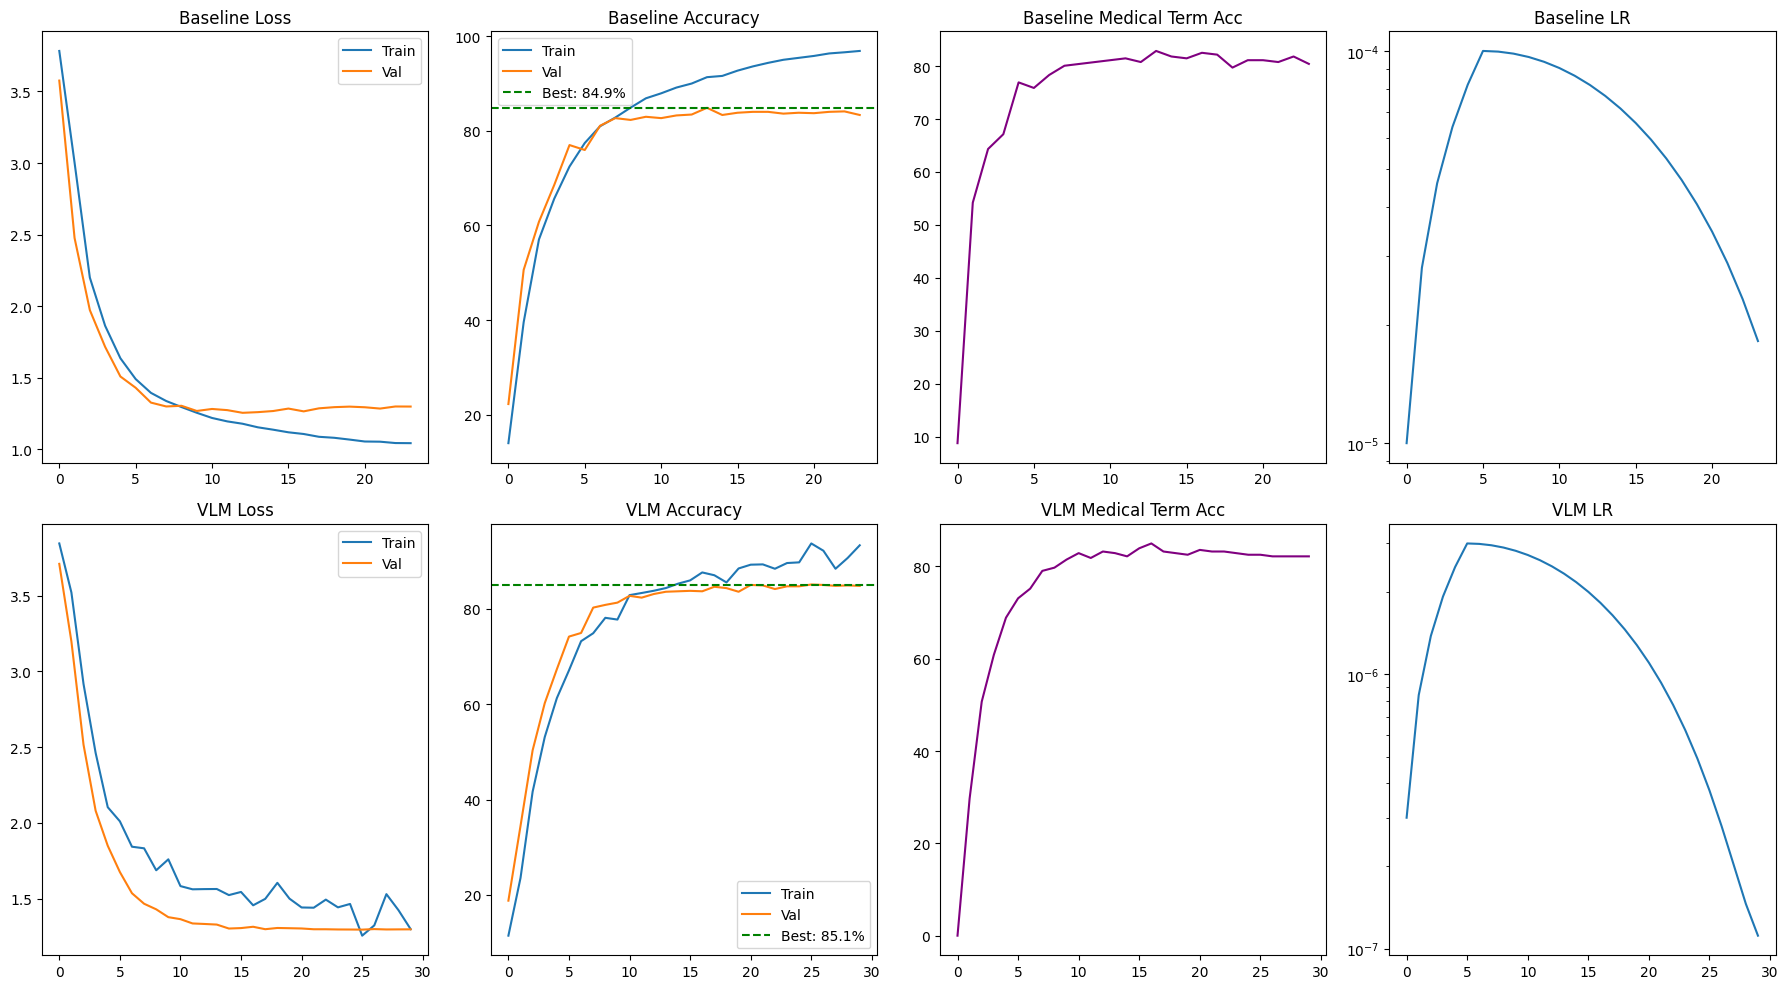


TRAINING ANALYSIS

--- Baseline Model ---
  Total epochs trained:    24
  Best epoch:              14
  Early stopped:           Yes (patience=10)
  Train accuracy (final):  96.93%
  Val accuracy (final):    83.38%
  Val accuracy (best):     84.90%
  Train-Val gap:           13.55%

--- VLM Model ---
  Total epochs trained:    30
  Best epoch:              26
  Early stopped:           No (patience=10)
  Train accuracy (final):  93.31%
  Val accuracy (final):    84.81%
  Val accuracy (best):     85.09%
  Train-Val gap:           8.51%


In [36]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Baseline
axes[0, 0].plot(baseline_history['train_loss'], label='Train')
axes[0, 0].plot(baseline_history['val_loss'], label='Val')
axes[0, 0].set_title('Baseline Loss')
axes[0, 0].legend()

axes[0, 1].plot(baseline_history['train_acc'], label='Train')
axes[0, 1].plot(baseline_history['val_acc'], label='Val')
axes[0, 1].axhline(max(baseline_history['val_acc']), c='g', ls='--', label=f'Best: {max(baseline_history["val_acc"]):.1f}%')
axes[0, 1].set_title('Baseline Accuracy')
axes[0, 1].legend()

axes[0, 2].plot(baseline_history['val_med_acc'], c='purple')
axes[0, 2].set_title('Baseline Medical Term Acc')

axes[0, 3].plot(baseline_history['lr'])
axes[0, 3].set_title('Baseline LR')
axes[0, 3].set_yscale('log')

# VLM
axes[1, 0].plot(vlm_history['train_loss'], label='Train')
axes[1, 0].plot(vlm_history['val_loss'], label='Val')
axes[1, 0].set_title('VLM Loss')
axes[1, 0].legend()

axes[1, 1].plot(vlm_history['train_acc'], label='Train')
axes[1, 1].plot(vlm_history['val_acc'], label='Val')
axes[1, 1].axhline(max(vlm_history['val_acc']), c='g', ls='--', label=f'Best: {max(vlm_history["val_acc"]):.1f}%')
axes[1, 1].set_title('VLM Accuracy')
axes[1, 1].legend()

axes[1, 2].plot(vlm_history['val_med_acc'], c='purple')
axes[1, 2].set_title('VLM Medical Term Acc')

axes[1, 3].plot(vlm_history['lr'])
axes[1, 3].set_title('VLM LR')
axes[1, 3].set_yscale('log')

plt.tight_layout()
plt.savefig(TRAINING_CURVES_PATH, dpi=150)
plt.show()

# Training Analysis
print("\n" + "=" * 70)
print("TRAINING ANALYSIS")
print("=" * 70)

# Baseline analysis
bl_best_epoch = baseline_history['val_acc'].index(max(baseline_history['val_acc'])) + 1
bl_total_epochs = len(baseline_history['val_acc'])
bl_train_final = baseline_history['train_acc'][-1]
bl_val_final = baseline_history['val_acc'][-1]
bl_val_best = max(baseline_history['val_acc'])
bl_gap = bl_train_final - bl_val_final

print(f"\n--- Baseline Model ---")
print(f"  Total epochs trained:    {bl_total_epochs}")
print(f"  Best epoch:              {bl_best_epoch}")
print(f"  Early stopped:           {'Yes' if bl_total_epochs < NUM_EPOCHS else 'No'} (patience={PATIENCE})")
print(f"  Train accuracy (final):  {bl_train_final:.2f}%")
print(f"  Val accuracy (final):    {bl_val_final:.2f}%")
print(f"  Val accuracy (best):     {bl_val_best:.2f}%")
print(f"  Train-Val gap:           {bl_gap:.2f}%")

# VLM analysis
vlm_best_epoch = vlm_history['val_acc'].index(max(vlm_history['val_acc'])) + 1
vlm_total_epochs = len(vlm_history['val_acc'])
vlm_train_final = vlm_history['train_acc'][-1]
vlm_val_final = vlm_history['val_acc'][-1]
vlm_val_best = max(vlm_history['val_acc'])
vlm_gap = vlm_train_final - vlm_val_final

print(f"\n--- VLM Model ---")
print(f"  Total epochs trained:    {vlm_total_epochs}")
print(f"  Best epoch:              {vlm_best_epoch}")
print(f"  Early stopped:           {'Yes' if vlm_total_epochs < NUM_EPOCHS else 'No'} (patience={PATIENCE})")
print(f"  Train accuracy (final):  {vlm_train_final:.2f}%")
print(f"  Val accuracy (final):    {vlm_val_final:.2f}%")
print(f"  Val accuracy (best):     {vlm_val_best:.2f}%")
print(f"  Train-Val gap:           {vlm_gap:.2f}%")




## 16. Ensemble Evaluation (α tuned on validation)

In [37]:
# Validation predictions
_, val_acc_bl, val_preds_bl, val_labels_bl, _, _, val_logits_bl, _ = evaluate(baseline_model, val_loader, criterion, device, 'baseline')
_, val_acc_vlm, val_preds_vlm, val_labels_vlm, _, _, val_logits_vlm, _ = evaluate(vlm_model, vlm_val_loader, vlm_criterion, device, 'vlm')
assert np.array_equal(val_labels_bl, val_labels_vlm)
print(f"Val: Baseline={val_acc_bl:.2f}%, VLM={val_acc_vlm:.2f}%")

Evaluating:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/33 [00:00<?, ?it/s]

Val: Baseline=84.90%, VLM=85.09%


In [38]:
# Error correlation
def error_correlation(pa, pb, labels, na, nb):
    n = len(labels)
    both_c = sum(1 for p1, p2, l in zip(pa, pb, labels) if p1 == l and p2 == l)
    both_w = sum(1 for p1, p2, l in zip(pa, pb, labels) if p1 != l and p2 != l)
    a_c = sum(1 for p1, p2, l in zip(pa, pb, labels) if p1 == l and p2 != l)
    b_c = sum(1 for p1, p2, l in zip(pa, pb, labels) if p1 != l and p2 == l)
    print(f"Both correct: {both_c}, Both wrong: {both_w}, {na}✓{nb}✗: {a_c}, {na}✗{nb}✓: {b_c}")
    print(f"Ensemble potential: {a_c + b_c} samples")

error_correlation(val_preds_bl, val_preds_vlm, val_labels_bl, "BL", "VLM")

Both correct: 852, Both wrong: 115, BL✓VLM✗: 42, BL✗VLM✓: 44
Ensemble potential: 86 samples


In [39]:
# Temperature scaling
def find_temp(logits, labels):
    lt = torch.tensor(labels)
    def nll(T):
        return -torch.log(F.softmax(logits / T, 1)[range(len(labels)), lt] + 1e-10).mean().item()
    return minimize_scalar(nll, bounds=(0.5, 5.0), method='bounded').x

T_bl = find_temp(val_logits_bl, val_labels_bl)
T_vlm = find_temp(val_logits_vlm, val_labels_vlm)
print(f"Temperature: Baseline={T_bl:.3f}, VLM={T_vlm:.3f}")

Temperature: Baseline=0.819, VLM=0.822


In [40]:
# Tune α on validation
best_alpha, best_val_ens = 0.5, 0
for alpha in np.arange(0.05, 0.95, 0.05):
    probs = alpha * F.softmax(val_logits_bl / T_bl, 1) + (1 - alpha) * F.softmax(val_logits_vlm / T_vlm, 1)
    acc = accuracy_score(val_labels_bl, probs.argmax(1).numpy()) * 100
    if acc > best_val_ens:
        best_val_ens, best_alpha = acc, alpha

print(f"\n★ Best α={best_alpha:.2f}, Val Ensemble={best_val_ens:.2f}%")


★ Best α=0.55, Val Ensemble=86.23%


In [41]:
# Final test evaluation
_, test_acc_bl, test_preds_bl, test_labels_bl, test_q_bl, test_a_bl, test_logits_bl, test_ct_bl = evaluate(baseline_model, test_loader, criterion, device, 'baseline')
_, test_acc_vlm, test_preds_vlm, test_labels_vlm, test_q_vlm, test_a_vlm, test_logits_vlm, test_ct_vlm = evaluate(vlm_model, vlm_test_loader, vlm_criterion, device, 'vlm')

# TTA
_, test_acc_bl_tta, _, _ = evaluate_with_tta(baseline_model, test_loader, criterion, device, 'baseline')
_, test_acc_vlm_tta, _, _ = evaluate_with_tta(vlm_model, vlm_test_loader, vlm_criterion, device, 'vlm')

# Ensemble
test_ens_probs = best_alpha * F.softmax(test_logits_bl / T_bl, 1) + (1 - best_alpha) * F.softmax(test_logits_vlm / T_vlm, 1)
test_ens_preds = test_ens_probs.argmax(1).numpy()
test_ens_acc = accuracy_score(test_labels_bl, test_ens_preds) * 100

print(f"\nTEST RESULTS:")
print(f"Baseline: {test_acc_bl:.2f}% (TTA: {test_acc_bl_tta:.2f}%)")
print(f"VLM: {test_acc_vlm:.2f}% (TTA: {test_acc_vlm_tta:.2f}%)")
print(f"Ensemble (α={best_alpha:.2f}): {test_ens_acc:.2f}%")

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

TTA:   0%|          | 0/34 [00:00<?, ?it/s]

TTA:   0%|          | 0/34 [00:00<?, ?it/s]


TEST RESULTS:
Baseline: 80.87% (TTA: 81.06%)
VLM: 83.88% (TTA: 82.47%)
Ensemble (α=0.55): 83.41%


### 17. Category-Aware Prediction Analysis

In [42]:
# ==================== CATEGORY-AWARE EVALUATION ====================
# Analyze predictions filtered by question type

def evaluate_with_categories(preds, labels, logits, questions, idx2answer, answer_category_lookup):
    """
    Evaluate with category-aware analysis.
    Shows how well the model performs when we filter predictions
    to the expected answer category.
    """
    results = {
        'standard_correct': 0,
        'filtered_correct': 0,
        'category_match': 0,  # prediction is in expected category
        'by_question_type': {},
        'examples': []
    }

    probs = F.softmax(logits, dim=1)
    n = len(preds)

    for i in range(n):
        pred_idx = int(preds[i])
        true_idx = int(labels[i])
        question = questions[i]

        # Standard accuracy
        if pred_idx == true_idx:
            results['standard_correct'] += 1

        # Get expected category
        expected_cat = categorize_question(question)
        pred_cat = answer_category_lookup.get(pred_idx, 'OTHER')
        true_cat = answer_category_lookup.get(true_idx, 'OTHER')

        # Category match
        if pred_cat == expected_cat:
            results['category_match'] += 1

        # Get filtered top-1
        filtered_preds, _ = get_filtered_topk(
            probs[i:i+1], question, idx2answer, answer_category_lookup, k=1
        )
        filtered_pred_idx = filtered_preds[0]['idx']

        if filtered_pred_idx == true_idx:
            results['filtered_correct'] += 1

        # Track by question type
        if expected_cat not in results['by_question_type']:
            results['by_question_type'][expected_cat] = {
                'total': 0, 'standard_correct': 0, 'filtered_correct': 0
            }
        results['by_question_type'][expected_cat]['total'] += 1
        if pred_idx == true_idx:
            results['by_question_type'][expected_cat]['standard_correct'] += 1
        if filtered_pred_idx == true_idx:
            results['by_question_type'][expected_cat]['filtered_correct'] += 1

        # Save example where filtering helps
        if filtered_pred_idx == true_idx and pred_idx != true_idx:
            results['examples'].append({
                'question': question,
                'true': idx2answer.get(true_idx, '?'),
                'standard_pred': idx2answer.get(pred_idx, '?'),
                'filtered_pred': idx2answer.get(filtered_pred_idx, '?'),
                'expected_category': expected_cat
            })

    results['standard_acc'] = 100 * results['standard_correct'] / n
    results['filtered_acc'] = 100 * results['filtered_correct'] / n
    results['category_match_rate'] = 100 * results['category_match'] / n

    return results


print("✓ Category-aware evaluation function defined")

✓ Category-aware evaluation function defined


In [43]:
# Run category-aware evaluation on ensemble
cat_eval = evaluate_with_categories(
    test_ens_preds, test_labels_bl, test_ens_probs,
    test_q_bl, idx2answer, answer_category_lookup
)

print("\n" + "=" * 70)
print("CATEGORY-AWARE PREDICTION ANALYSIS")
print("=" * 70)

print(f"\nOverall:")
print(f"  Standard Accuracy:     {cat_eval['standard_acc']:.2f}%")
print(f"  Category-Filtered Acc: {cat_eval['filtered_acc']:.2f}%")
print(f"  Improvement:           {cat_eval['filtered_acc'] - cat_eval['standard_acc']:+.2f}%")
print(f"  Category Match Rate:   {cat_eval['category_match_rate']:.2f}%")

print(f"\nBy Question Type:")
print(f"{'Type':<15} {'N':<6} {'Standard':<12} {'Filtered':<12} {'Δ':<8}")
print("-" * 55)
for qtype, stats in sorted(cat_eval['by_question_type'].items(), key=lambda x: -x[1]['total']):
    std_acc = 100 * stats['standard_correct'] / stats['total']
    flt_acc = 100 * stats['filtered_correct'] / stats['total']
    delta = flt_acc - std_acc
    print(f"{qtype:<15} {stats['total']:<6} {std_acc:.1f}%{'':<6} {flt_acc:.1f}%{'':<6} {delta:+.1f}%")


CATEGORY-AWARE PREDICTION ANALYSIS

Overall:
  Standard Accuracy:     83.41%
  Category-Filtered Acc: 55.70%
  Improvement:           -27.71%
  Category Match Rate:   56.08%

By Question Type:
Type            N      Standard     Filtered     Δ       
-------------------------------------------------------
YES_NO          350    92.0%       67.1%       -24.9%
ORGAN           284    88.4%       48.6%       -39.8%
OTHER           112    85.7%       85.7%       +0.0%
POSITION        109    55.0%       18.3%       -36.7%
CONDITION       69     47.8%       5.8%       -42.0%
MODALITY        58     98.3%       89.7%       -8.6%
COUNT           33     87.9%       87.9%       +0.0%
SIZE            26     73.1%       3.8%       -69.2%
COLOR           13     100.0%       100.0%       +0.0%
SHAPE           7      71.4%       42.9%       -28.6%


In [44]:
# Show examples where category filtering helped
if cat_eval['examples']:
    print("\nExamples where category filtering IMPROVED prediction:")
    for ex in cat_eval['examples'][:5]:
        print(f"\n  Q: {ex['question'][:60]}...")
        print(f"  Expected category: {ex['expected_category']}")
        print(f"  Standard pred: '{ex['standard_pred']}' ✗")
        print(f"  Filtered pred: '{ex['filtered_pred']}' ✓")
        print(f"  True answer: '{ex['true']}'")
else:
    print("\nNo examples where filtering improved prediction.")


Examples where category filtering IMPROVED prediction:

  Q: What diseases are included in the picture?...
  Expected category: CONDITION
  Standard pred: 'cardiomegaly' ✗
  Filtered pred: 'nodule' ✓
  True answer: 'nodule'

  Q: What is the main organ in the image?...
  Expected category: ORGAN
  Standard pred: '<UNK>' ✗
  Filtered pred: 'liver' ✓
  True answer: 'liver'


In [45]:
# ==================== NATURAL LANGUAGE RESPONSE EXAMPLES ====================

print("\n" + "=" * 70)
print("NATURAL LANGUAGE RESPONSE EXAMPLES")
print("=" * 70)

# Pick some random test samples
sample_indices = random.sample(range(len(test_q_bl)), min(5, len(test_q_bl)))

for idx in sample_indices:
    question = test_q_bl[idx]
    true_answer = test_a_bl[idx]
    pred_idx = int(test_ens_preds[idx])
    pred_answer = idx2answer.get(pred_idx, '<UNK>')

    # Get filtered predictions
    probs = test_ens_probs[idx:idx+1]
    filtered_preds, expected_cat = get_filtered_topk(
        probs, question, idx2answer, answer_category_lookup, k=5
    )
    confidence = filtered_preds[0]['prob'] * 100

    # Generate natural response
    response = generate_natural_response(
        filtered_preds[0]['answer'], question, confidence, filtered_preds
    )

    print(f"\n{'─'*60}")
    print(f"Q: {question}")
    print(f"True: {true_answer}")
    print(f"\nResponse:\n{response}")


NATURAL LANGUAGE RESPONSE EXAMPLES

────────────────────────────────────────────────────────────
Q: Which part of the body does this image belong to?
True: Abdomen

Response:
The answer is **abdomen**. (Moderate confidence: 68.7%)

**Other possibilities:**
- chest (25.4%)
- mri (0.2%)
- lung (0.1%)

────────────────────────────────────────────────────────────
Q: Where is/are the abnormality located?
True: Left Lung, Lower Right

Response:
The location is **left lung, right**. (Moderate confidence: 65.0%)

**Other possibilities:**
- right lung, left (2.7%)
- left lung, upper right (1.0%)
- right lung, upper left (1.0%)

────────────────────────────────────────────────────────────
Q: What disease is/are shown on the lower left of lung?
True: Pulmonary Infiltration

Response:
⚠️ Low confidence: The finding suggests **pulmonary mass**. (20.0%)

**Other possibilities:**
- pneumonia (15.8%)
- nodule (6.0%)
- pulmonary nodule (4.8%)

──────────────────────────────────────────────────────────

## 18. Flexible Accuracy and Error Breakdown

Performance by Question Type (Flexible Matching):
Baseline - Closed: 87.02% (416 samples)
Baseline - Open: 81.09% (645 samples)
VLM - Closed: 87.02% (416 samples)
VLM - Open: 85.58% (645 samples)
Ensemble - Closed: 87.98% (416 samples)
Ensemble - Open: 84.65% (645 samples)


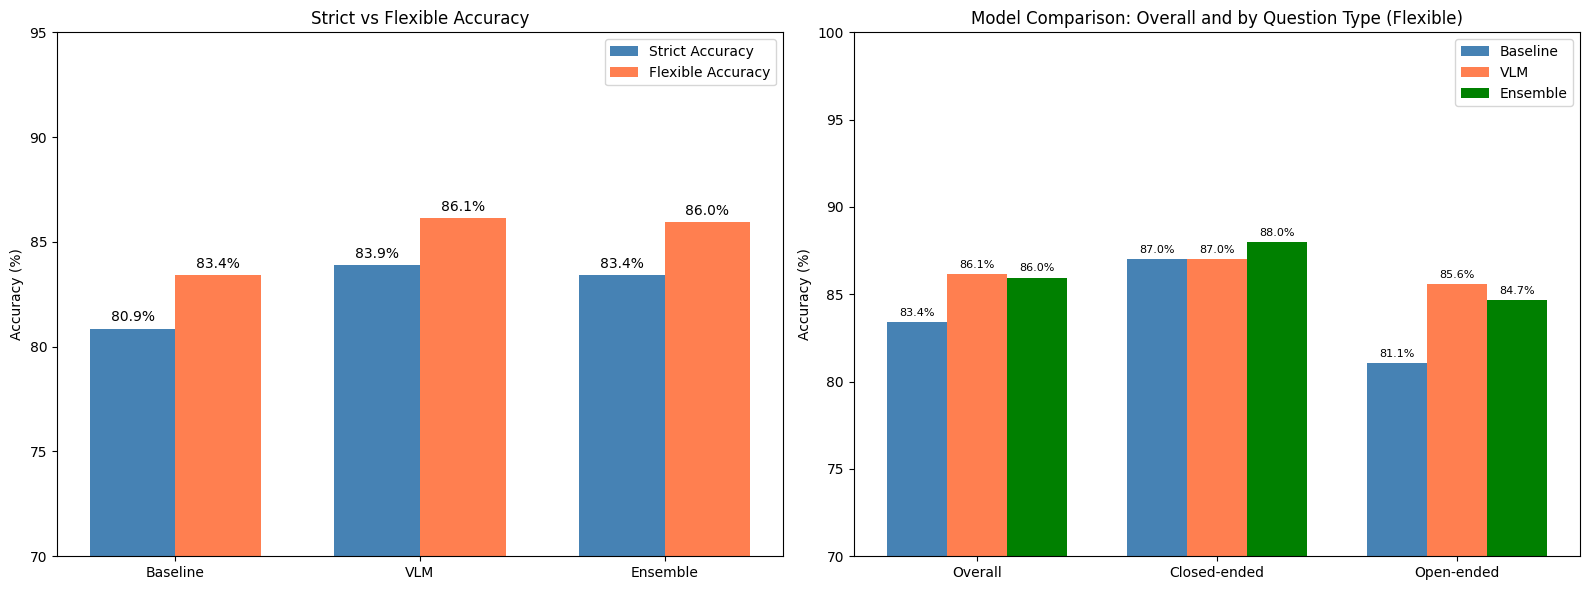


ACCURACY SUMMARY
Metric                         Baseline        VLM             Ensemble       
--------------------------------------------------------------------------------
Strict Accuracy                80.87%          83.88%          83.41%
Flexible Accuracy              83.41%          86.15%          85.96%
Improvement (Flexible)         +2.54%         +2.26%         +2.54%
True Error Rate                16.59%          13.85%          14.04%
--------------------------------------------------------------------------------
Closed-ended (Flexible)        87.02%          87.02%          87.98%
Open-ended (Flexible)          81.09%          85.58%          84.65%


In [46]:
# ==================== MODEL COMPARISON VISUALIZATION ====================
# Analyze performance by question type for all models (Baseline, VLM, Ensemble)

def analyze_by_question_type(preds, labels, answer_types, idx2answer):
    """Analyze accuracy by question type (CLOSED vs OPEN) with flexible matching"""
    closed_strict, closed_flex, closed_total = 0, 0, 0
    open_strict, open_flex, open_total = 0, 0, 0

    for pred, label, ans_type in zip(preds, labels, answer_types):
        pred_ans = idx2answer.get(int(pred), '')
        true_ans = idx2answer.get(int(label), '')
        is_strict = (pred == label)
        is_flex = is_strict or flexible_match(pred_ans, true_ans)

        if ans_type == 'CLOSED':
            closed_total += 1
            if is_strict: closed_strict += 1
            if is_flex: closed_flex += 1
        else:
            open_total += 1
            if is_strict: open_strict += 1
            if is_flex: open_flex += 1

    return {
        'closed_strict': 100 * closed_strict / closed_total if closed_total > 0 else 0,
        'closed_flex': 100 * closed_flex / closed_total if closed_total > 0 else 0,
        'open_strict': 100 * open_strict / open_total if open_total > 0 else 0,
        'open_flex': 100 * open_flex / open_total if open_total > 0 else 0,
        'closed_total': closed_total,
        'open_total': open_total
    }

# Get answer types
test_ans_types = [test_dataset.data[i].get('answer_type', 'OPEN') for i in range(len(test_preds_bl))]

# Analyze all models with flexible matching
bl_analysis = analyze_by_question_type(test_preds_bl, test_labels_bl, test_ans_types, idx2answer)
vlm_analysis = analyze_by_question_type(test_preds_vlm, test_labels_vlm, test_ans_types, idx2answer)
ens_analysis = analyze_by_question_type(test_ens_preds, test_labels_bl, test_ans_types, idx2answer)

# Calculate overall flexible accuracy
def calc_flexible_acc(preds, labels, idx2answer):
    strict, flex = 0, 0
    for p, l in zip(preds, labels):
        if p == l:
            strict += 1
            flex += 1
        elif flexible_match(idx2answer.get(int(p), ''), idx2answer.get(int(l), '')):
            flex += 1
    n = len(preds)
    return 100 * strict / n, 100 * flex / n

test_acc_bl_strict, test_acc_bl_flexible = calc_flexible_acc(test_preds_bl, test_labels_bl, idx2answer)
test_acc_vlm_strict, test_acc_vlm_flexible = calc_flexible_acc(test_preds_vlm, test_labels_vlm, idx2answer)
ensemble_acc_strict, ensemble_flex_acc = calc_flexible_acc(test_ens_preds, test_labels_bl, idx2answer)

print("Performance by Question Type (Flexible Matching):")
print(f"Baseline - Closed: {bl_analysis['closed_flex']:.2f}% ({bl_analysis['closed_total']} samples)")
print(f"Baseline - Open: {bl_analysis['open_flex']:.2f}% ({bl_analysis['open_total']} samples)")
print(f"VLM - Closed: {vlm_analysis['closed_flex']:.2f}% ({vlm_analysis['closed_total']} samples)")
print(f"VLM - Open: {vlm_analysis['open_flex']:.2f}% ({vlm_analysis['open_total']} samples)")
print(f"Ensemble - Closed: {ens_analysis['closed_flex']:.2f}% ({ens_analysis['closed_total']} samples)")
print(f"Ensemble - Open: {ens_analysis['open_flex']:.2f}% ({ens_analysis['open_total']} samples)")

# Create comparison figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Strict vs Flexible Accuracy (3 models)
ax1 = axes[0]
x1 = np.arange(3)
width = 0.35

strict_scores = [test_acc_bl_strict, test_acc_vlm_strict, ensemble_acc_strict]
flexible_scores = [test_acc_bl_flexible, test_acc_vlm_flexible, ensemble_flex_acc]

bars1 = ax1.bar(x1 - width/2, strict_scores, width, label='Strict Accuracy', color='steelblue')
bars2 = ax1.bar(x1 + width/2, flexible_scores, width, label='Flexible Accuracy', color='coral')

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Strict vs Flexible Accuracy')
ax1.set_xticks(x1)
ax1.set_xticklabels(['Baseline', 'VLM', 'Ensemble'])
ax1.legend()
ax1.set_ylim(70, 95)

for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Subplot 2: Performance by Question Type (3 models) - Using Flexible Accuracy
ax2 = axes[1]
x2 = np.arange(3)
width = 0.25

baseline_scores = [test_acc_bl_flexible, bl_analysis['closed_flex'], bl_analysis['open_flex']]
vlm_scores = [test_acc_vlm_flexible, vlm_analysis['closed_flex'], vlm_analysis['open_flex']]
ensemble_scores = [ensemble_flex_acc, ens_analysis['closed_flex'], ens_analysis['open_flex']]

bars3 = ax2.bar(x2 - width, baseline_scores, width, label='Baseline', color='steelblue')
bars4 = ax2.bar(x2, vlm_scores, width, label='VLM', color='coral')
bars5 = ax2.bar(x2 + width, ensemble_scores, width, label='Ensemble', color='green')

ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Model Comparison: Overall and by Question Type (Flexible)')
ax2.set_xticks(x2)
ax2.set_xticklabels(['Overall', 'Closed-ended', 'Open-ended'])
ax2.legend()
ax2.set_ylim(70, 100)

for bar in bars3:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars4:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars5:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'model_comparison.png'), dpi=150)
plt.show()

# Summary Table
print("\n" + "="*80)
print("ACCURACY SUMMARY")
print("="*80)
print(f"{'Metric':<30} {'Baseline':<15} {'VLM':<15} {'Ensemble':<15}")
print("-"*80)
print(f"{'Strict Accuracy':<30} {test_acc_bl_strict:.2f}%{'':<9} {test_acc_vlm_strict:.2f}%{'':<9} {ensemble_acc_strict:.2f}%")
print(f"{'Flexible Accuracy':<30} {test_acc_bl_flexible:.2f}%{'':<9} {test_acc_vlm_flexible:.2f}%{'':<9} {ensemble_flex_acc:.2f}%")
print(f"{'Improvement (Flexible)':<30} +{test_acc_bl_flexible-test_acc_bl_strict:.2f}%{'':<8} +{test_acc_vlm_flexible-test_acc_vlm_strict:.2f}%{'':<8} +{ensemble_flex_acc-ensemble_acc_strict:.2f}%")
print(f"{'True Error Rate':<30} {100-test_acc_bl_flexible:.2f}%{'':<9} {100-test_acc_vlm_flexible:.2f}%{'':<9} {100-ensemble_flex_acc:.2f}%")
print("-"*80)
print(f"{'Closed-ended (Flexible)':<30} {bl_analysis['closed_flex']:.2f}%{'':<9} {vlm_analysis['closed_flex']:.2f}%{'':<9} {ens_analysis['closed_flex']:.2f}%")
print(f"{'Open-ended (Flexible)':<30} {bl_analysis['open_flex']:.2f}%{'':<9} {vlm_analysis['open_flex']:.2f}%{'':<9} {ens_analysis['open_flex']:.2f}%")
print("="*80)

In [63]:
# ==================== ERROR BREAKDOWN TABLE ====================

print("\n" + "=" * 80)
print("ERROR BREAKDOWN")
print("=" * 80)

test_ans_types = [test_dataset.data[i].get('answer_type', 'OPEN') for i in range(len(test_preds_bl))]

bl_flex = calculate_flexible_accuracy(test_preds_bl, test_labels_bl, idx2answer, test_ans_types)
vlm_flex = calculate_flexible_accuracy(test_preds_vlm, test_labels_vlm, idx2answer, test_ans_types)
ens_flex = calculate_flexible_accuracy(test_ens_preds, test_labels_bl, idx2answer, test_ans_types)

print("✓ Computed flexible accuracy metrics")
print(f"  Baseline: {bl_flex['flexible_acc']:.2f}%")
print(f"  VLM: {vlm_flex['flexible_acc']:.2f}%")
print(f"  Ensemble: {ens_flex['flexible_acc']:.2f}%")

for name, flex_m in [("Baseline", bl_flex), ("VLM", vlm_flex), ("Ensemble", ens_flex)]:
    total = len(test_labels_bl)
    strict_correct = int(flex_m['strict_acc'] * total / 100)
    flexible_correct = int(flex_m['flexible_acc'] * total / 100)
    strict_errors = total - strict_correct
    true_errors = total - flexible_correct
    semantic_fixed = strict_errors - true_errors

    print(f"\n{name}:")
    print(f"  Total samples: {total}")
    print(f"  ✓ Correct (strict): {strict_correct} ({flex_m['strict_acc']:.2f}%)")
    print(f"  ✓ Correct (flexible): {flexible_correct} ({flex_m['flexible_acc']:.2f}%)")
    print(f"  ✗ Strict errors: {strict_errors} ({100-flex_m['strict_acc']:.2f}%)")
    print(f"    ├─ True errors: {true_errors} ({100-flex_m['flexible_acc']:.2f}%) ← Real mistakes")
    print(f"    └─ Semantic match: {semantic_fixed} ({flex_m['flexible_acc']-flex_m['strict_acc']:.2f}%) ← Acceptable")


ERROR BREAKDOWN
✓ Computed flexible accuracy metrics
  Baseline: 83.41%
  VLM: 86.15%
  Ensemble: 85.96%

Baseline:
  Total samples: 1061
  ✓ Correct (strict): 858 (80.87%)
  ✓ Correct (flexible): 885 (83.41%)
  ✗ Strict errors: 203 (19.13%)
    ├─ True errors: 176 (16.59%) ← Real mistakes
    └─ Semantic match: 27 (2.54%) ← Acceptable

VLM:
  Total samples: 1061
  ✓ Correct (strict): 890 (83.88%)
  ✓ Correct (flexible): 914 (86.15%)
  ✗ Strict errors: 171 (16.12%)
    ├─ True errors: 147 (13.85%) ← Real mistakes
    └─ Semantic match: 24 (2.26%) ← Acceptable

Ensemble:
  Total samples: 1061
  ✓ Correct (strict): 885 (83.41%)
  ✓ Correct (flexible): 912 (85.96%)
  ✗ Strict errors: 176 (16.59%)
    ├─ True errors: 149 (14.04%) ← Real mistakes
    └─ Semantic match: 27 (2.54%) ← Acceptable


## 19. Word-Level Error Categorization (Clinical Impact)

In [48]:
# ==================== WORD-LEVEL ERROR ANALYSIS ====================

def categorize_errors(pred_indices, true_indices, idx2answer, answer_types):
    """Categorize errors by clinical impact"""
    LATERALITY = {'left', 'right', 'bilateral', 'upper', 'lower', 'anterior', 'posterior'}
    ORGANS = {'liver', 'kidney', 'lung', 'heart', 'brain', 'spleen', 'pancreas', 'stomach', 'colon'}
    CONDITIONS = {'tumor', 'fracture', 'pneumonia', 'edema', 'lesion', 'nodule', 'cancer'}

    categories = {'laterality': [], 'organ': [], 'condition': [], 'yes_no': [], 'partial': [], 'other': []}

    for pred_idx, true_idx, ans_type in zip(pred_indices, true_indices, answer_types):
        if pred_idx == true_idx:
            continue

        pred = idx2answer.get(int(pred_idx), '')
        true = idx2answer.get(int(true_idx), '')

        # Use flexible_match for consistency (check FIRST)
        if flexible_match(pred, true):
            categories['partial'].append({'pred': pred, 'true': true})
            continue

        pred_lower = pred.lower()
        true_lower = true.lower()

        # Yes/No
        if true_lower in ['yes', 'no'] or pred_lower in ['yes', 'no']:
            categories['yes_no'].append({'pred': pred, 'true': true})
            continue

        pred_words = set(pred_lower.split())
        true_words = set(true_lower.split())
        wrong = (true_words - pred_words) | (pred_words - true_words)

        if wrong & LATERALITY:
            categories['laterality'].append({'pred': pred, 'true': true, 'wrong': wrong & LATERALITY})
        elif wrong & ORGANS:
            categories['organ'].append({'pred': pred, 'true': true, 'wrong': wrong & ORGANS})
        elif wrong & CONDITIONS:
            categories['condition'].append({'pred': pred, 'true': true})
        else:
            categories['other'].append({'pred': pred, 'true': true})

    return categories

error_cats = categorize_errors(test_preds_vlm, test_labels_vlm, idx2answer, test_ans_types)

print("\n" + "=" * 80)
print("ERROR CATEGORIZATION BY CLINICAL IMPACT (VLM)")
print("=" * 80)

total_samples = len(test_preds_vlm)
partial_count = len(error_cats['partial'])
true_error_cats = ['laterality', 'organ', 'condition', 'yes_no', 'other']
true_errors = sum(len(error_cats[cat]) for cat in true_error_cats)
total_strict = partial_count + true_errors

print(f"\nTotal strict errors: {total_strict} / {total_samples} ({100*total_strict/total_samples:.2f}%)")
print(f"  - Semantic matches (not true errors): {partial_count} ({100*partial_count/total_samples:.2f}%)")
print(f"  - TRUE errors: {true_errors} ({100*true_errors/total_samples:.2f}%)")

impact = {
    'laterality': '🔴 HIGH (wrong side)',
    'organ': '🔴 HIGH (wrong organ)',
    'condition': '🔴 HIGH (wrong diagnosis)',
    'yes_no': '🟡 MEDIUM (binary flip)',
    'other': '⚪ VARIES'
}

print(f"\n--- Breakdown of {true_errors} TRUE Errors ---")
print(f"\n{'Category':<15} {'Count':<8} {'%':<8} {'Clinical Impact':<25}")
print("-" * 60)
running_total = 0
for cat in true_error_cats:
    count = len(error_cats[cat])
    running_total += count
    pct = 100 * count / true_errors if true_errors > 0 else 0
    print(f"{cat:<15} {count:<8} {pct:.1f}%{'':<4} {impact[cat]}")

print("-" * 60)
print(f"{'TOTAL':<15} {running_total:<8} {'100.0%':<8}")

# HIGH impact errors
high_impact = len(error_cats['laterality']) + len(error_cats['organ']) + len(error_cats['condition'])
print(f"\n→ HIGH impact errors: {high_impact}/{true_errors} ({100*high_impact/true_errors:.1f}% of true errors)")



print("\n" + "=" * 60)
print("ERROR ANALYSIS (VLM) - with Flexible Matching")
print("=" * 60)

# Find errors - distinguish between strict and flexible
strict_errors = []
flexible_fixed = []

for i, (pred, label) in enumerate(zip(test_preds_vlm, test_labels_vlm)):
    if pred != label:
        pred_answer = idx2answer.get(int(pred), '<UNK>')
        true_answer = idx2answer.get(int(label), '<UNK>')

        # Get question and content type from dataset
        item = vlm_test_dataset.data[i]

        error_info = {
            'question': item['question'],
            'true_answer': item['answer'],
            'predicted': pred_answer,
            'content_type': item.get('content_type', 'unknown')
        }

        if flexible_match(pred_answer, true_answer):
            flexible_fixed.append(error_info)
        else:
            strict_errors.append(error_info)

total_strict_errors = len(strict_errors) + len(flexible_fixed)
print(f"\nStrict errors: {total_strict_errors} / {len(test_preds_vlm)} ({100*total_strict_errors/len(test_preds_vlm):.2f}%)")
print(f"  - True errors: {len(strict_errors)} ({100*len(strict_errors)/len(test_preds_vlm):.2f}%)")
print(f"  - Fixed by flexible matching: {len(flexible_fixed)} ({100*len(flexible_fixed)/len(test_preds_vlm):.2f}%)")

if flexible_fixed:
    print("\n--- Examples FIXED by Flexible Matching ---")
    for i, err in enumerate(flexible_fixed[:5]):
        print(f"  [{i+1}] Pred: '{err['predicted']}' ✓ True: '{err['true_answer']}'")

print("\n--- Sample TRUE Errors (not fixable) ---")
for i, err in enumerate(strict_errors[:10]):
    print(f"\n[{i+1}] Q: {err['question']}")
    print(f"    True: {err['true_answer']}")
    print(f"    Pred: {err['predicted']}")
    print(f"    Type: {err['content_type']}")

print("\n--- Most Common Wrong Predictions (True Errors) ---")
wrong_preds = Counter([e['predicted'] for e in strict_errors])
for pred, count in wrong_preds.most_common(10):
    print(f"  {pred}: {count} times")


ERROR CATEGORIZATION BY CLINICAL IMPACT (VLM)

Total strict errors: 171 / 1061 (16.12%)
  - Semantic matches (not true errors): 24 (2.26%)
  - TRUE errors: 147 (13.85%)

--- Breakdown of 147 TRUE Errors ---

Category        Count    %        Clinical Impact          
------------------------------------------------------------
laterality      27       18.4%     🔴 HIGH (wrong side)
organ           24       16.3%     🔴 HIGH (wrong organ)
condition       7        4.8%     🔴 HIGH (wrong diagnosis)
yes_no          42       28.6%     🟡 MEDIUM (binary flip)
other           47       32.0%     ⚪ VARIES
------------------------------------------------------------
TOTAL           147      100.0%  

→ HIGH impact errors: 58/147 (39.5% of true errors)

ERROR ANALYSIS (VLM) - with Flexible Matching

Strict errors: 171 / 1061 (16.12%)
  - True errors: 147 (13.85%)
  - Fixed by flexible matching: 24 (2.26%)

--- Examples FIXED by Flexible Matching ---
  [1] Pred: 'left lung, right' ✓ True: 'Right Lun

## 20. Content Type and Medical Term Accuracy

In [49]:
def by_content_type(preds, labels, cts):
    r = {}
    for ct, p, l in zip(cts, preds, labels):
        if ct not in r: r[ct] = {'c': 0, 't': 0}
        r[ct]['t'] += 1
        if p == l: r[ct]['c'] += 1
    return r

bl_ct = by_content_type(test_preds_bl, test_labels_bl, test_ct_bl)
vlm_ct = by_content_type(test_preds_vlm, test_labels_vlm, test_ct_vlm)
ens_ct = by_content_type(test_ens_preds, test_labels_bl, test_ct_bl)

# Calculate overall
total_n = sum(bl_ct[ct]['t'] for ct in bl_ct)
bl_overall = 100 * sum(bl_ct[ct]['c'] for ct in bl_ct) / total_n
vlm_overall = 100 * sum(vlm_ct[ct]['c'] for ct in vlm_ct) / total_n
ens_overall = 100 * sum(ens_ct[ct]['c'] for ct in ens_ct) / total_n

print("\n" + "=" * 80)
print("PERFORMANCE BY CONTENT TYPE")
print("=" * 80)
print(f"\n{'Type':<15} {'N':<6} {'BL':<10} {'VLM':<10} {'Ens':<10} {'Δ (VLM-BL)':<10}")
print("-" * 70)
for ct in sorted(bl_ct.keys()):
    n = bl_ct[ct]['t']
    bl_a = 100 * bl_ct[ct]['c'] / n
    vlm_a = 100 * vlm_ct[ct]['c'] / n
    ens_a = 100 * ens_ct[ct]['c'] / n
    print(f"{ct:<15} {n:<6} {bl_a:<10.1f} {vlm_a:<10.1f} {ens_a:<10.1f} {vlm_a-bl_a:+.1f}")

print("-" * 70)
print(f"{'OVERALL':<15} {total_n:<6} {bl_overall:<10.1f} {vlm_overall:<10.1f} {ens_overall:<10.1f} {vlm_overall-bl_overall:+.1f}")


PERFORMANCE BY CONTENT TYPE

Type            N      BL         VLM        Ens        Δ (VLM-BL)
----------------------------------------------------------------------
Abnormality     150    69.3       76.0       72.7       +6.7
Color           34     82.4       94.1       85.3       +11.8
KG              148    78.4       76.4       77.7       -2.0
Modality        108    97.2       99.1       98.1       +1.9
Organ           253    90.1       87.7       90.9       -2.4
Plane           58     98.3       98.3       98.3       +0.0
Position        186    65.1       74.2       73.1       +9.1
Quantity        52     71.2       82.7       76.9       +11.5
Shape           7      57.1       85.7       71.4       +28.6
Size            65     89.2       89.2       89.2       +0.0
----------------------------------------------------------------------
OVERALL         1061   80.9       83.9       83.4       +3.0


In [50]:
# Medical term accuracy
def med_term_acc(preds, labels, idx2answer):
    c, t = 0, 0
    for p, l in zip(preds, labels):
        true_t = set(idx2answer.get(int(l), '').lower().split()) & MEDICAL_TERMS
        if true_t:
            t += 1
            pred_t = set(idx2answer.get(int(p), '').lower().split()) & MEDICAL_TERMS
            if pred_t == true_t: c += 1
    return 100 * c / t if t > 0 else 0, t

med_bl, med_n = med_term_acc(test_preds_bl, test_labels_bl, idx2answer)
med_vlm, _ = med_term_acc(test_preds_vlm, test_labels_vlm, idx2answer)
med_ens, _ = med_term_acc(test_ens_preds, test_labels_bl, idx2answer)

print(f"\nMedical Term Accuracy (n={med_n}): BL={med_bl:.2f}%, VLM={med_vlm:.2f}%, Ens={med_ens:.2f}%")


Medical Term Accuracy (n=310): BL=74.84%, VLM=81.29%, Ens=79.68%


## 21. Comprehensive Metrics

In [51]:
# Install additional packages for comprehensive metrics
!pip install -q bert-score rouge-score sentence-transformers

from bert_score import score as bert_score
from rouge_score import rouge_scorer
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

def compute_all_metrics(predictions, references, answer_types, model_logits=None, labels=None):
    """Compute comprehensive metrics for Med-VQA evaluation"""
    results = {}
    smoothie = SmoothingFunction().method1

    # Separate by question type
    closed_preds, closed_refs = [], []
    open_preds, open_refs = [], []

    for pred, ref, ans_type in zip(predictions, references, answer_types):
        if ans_type == 'CLOSED':
            closed_preds.append(pred.lower().strip())
            closed_refs.append(ref.lower().strip())
        else:
            open_preds.append(pred.lower().strip())
            open_refs.append(ref.lower().strip())

    # 1. Exact Match Accuracy
    print("  Computing Exact Match...")
    all_exact = [1 if p.lower().strip() == r.lower().strip() else 0 for p, r in zip(predictions, references)]
    closed_exact = [1 if p == r else 0 for p, r in zip(closed_preds, closed_refs)]
    open_exact = [1 if p == r else 0 for p, r in zip(open_preds, open_refs)]

    results['exact_match_overall'] = np.mean(all_exact) * 100
    results['exact_match_closed'] = np.mean(closed_exact) * 100 if closed_exact else 0
    results['exact_match_open'] = np.mean(open_exact) * 100 if open_exact else 0

    # 2. BERTScore
    print("  Computing BERTScore...")
    P, R, F1 = bert_score(predictions, references, lang='en', verbose=False)
    results['bertscore_precision'] = P.mean().item() * 100
    results['bertscore_recall'] = R.mean().item() * 100
    results['bertscore_f1'] = F1.mean().item() * 100

    if open_preds:
        P_open, R_open, F1_open = bert_score(open_preds, open_refs, lang='en', verbose=False)
        results['bertscore_f1_open'] = F1_open.mean().item() * 100
    else:
        results['bertscore_f1_open'] = 0

    # 3. ROUGE-L Score
    print("  Computing ROUGE-L...")
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(ref, pred)['rougeL'].fmeasure for pred, ref in zip(predictions, references)]
    results['rouge_l_overall'] = np.mean(rouge_scores) * 100

    if open_preds:
        rouge_open = [scorer.score(ref, pred)['rougeL'].fmeasure for pred, ref in zip(open_preds, open_refs)]
        results['rouge_l_open'] = np.mean(rouge_open) * 100
    else:
        results['rouge_l_open'] = 0

    # 4. Macro/Weighted F1 Score
    print("  Computing F1 Scores...")
    unique_labels = list(set(references))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    pred_indices = [label_to_idx.get(p.lower().strip(), -1) for p in predictions]
    ref_indices = [label_to_idx.get(r.lower().strip(), 0) for r in references]
    valid_pairs = [(p, r) for p, r in zip(pred_indices, ref_indices) if p != -1]
    if valid_pairs:
        valid_preds, valid_refs = zip(*valid_pairs)
        results['macro_f1'] = f1_score(valid_refs, valid_preds, average='macro', zero_division=0) * 100
        results['weighted_f1'] = f1_score(valid_refs, valid_preds, average='weighted', zero_division=0) * 100
    else:
        results['macro_f1'] = results['weighted_f1'] = 0

    # 5. BLEU Scores
    print("  Computing BLEU scores...")
    bleu1, bleu2, bleu3, bleu4 = [], [], [], []
    for pred, ref in zip(predictions, references):
        pred_tokens = word_tokenize(pred.lower())
        ref_tokens = [word_tokenize(ref.lower())]
        bleu1.append(sentence_bleu(ref_tokens, pred_tokens, weights=(1,0,0,0), smoothing_function=smoothie))
        bleu2.append(sentence_bleu(ref_tokens, pred_tokens, weights=(0.5,0.5,0,0), smoothing_function=smoothie))
        bleu3.append(sentence_bleu(ref_tokens, pred_tokens, weights=(0.33,0.33,0.33,0), smoothing_function=smoothie))
        bleu4.append(sentence_bleu(ref_tokens, pred_tokens, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie))
    results['bleu_1'] = np.mean(bleu1) * 100
    results['bleu_2'] = np.mean(bleu2) * 100
    results['bleu_3'] = np.mean(bleu3) * 100
    results['bleu_4'] = np.mean(bleu4) * 100

    # 6. Token-level F1
    print("  Computing Token F1...")
    token_f1_scores = []
    for pred, ref in zip(predictions, references):
        pred_tokens = set(word_tokenize(pred.lower()))
        ref_tokens = set(word_tokenize(ref.lower()))
        if len(pred_tokens) == 0 or len(ref_tokens) == 0:
            token_f1_scores.append(0)
            continue
        precision = len(pred_tokens & ref_tokens) / len(pred_tokens)
        recall = len(pred_tokens & ref_tokens) / len(ref_tokens)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        token_f1_scores.append(f1)
    results['token_f1'] = np.mean(token_f1_scores) * 100

    # 7. Semantic Similarity
    print("  Computing Semantic Similarity...")
    sent_model = SentenceTransformer('all-MiniLM-L6-v2')
    pred_embeddings = sent_model.encode(predictions)
    ref_embeddings = sent_model.encode(references)
    similarities = [cosine_similarity([p], [r])[0][0] for p, r in zip(pred_embeddings, ref_embeddings)]
    results['semantic_similarity'] = np.mean(similarities) * 100

    if open_preds:
        open_pred_emb = sent_model.encode(open_preds)
        open_ref_emb = sent_model.encode(open_refs)
        open_sims = [cosine_similarity([p], [r])[0][0] for p, r in zip(open_pred_emb, open_ref_emb)]
        results['semantic_similarity_open'] = np.mean(open_sims) * 100
    else:
        results['semantic_similarity_open'] = 0

    # 8. Levenshtein Ratio
    print("  Computing Levenshtein Ratio...")
    from difflib import SequenceMatcher
    lev_ratios = [SequenceMatcher(None, p.lower(), r.lower()).ratio() for p, r in zip(predictions, references)]
    results['levenshtein_ratio'] = np.mean(lev_ratios) * 100

    # 9. Top-K Accuracy
    print("  Computing Top-K Accuracy...")
    if model_logits is not None and labels is not None:
        probs = F.softmax(model_logits, dim=1)
        for k in [3, 5, 10]:
            top_k = probs.topk(k, dim=1).indices
            correct = sum(1 for i, label in enumerate(labels) if label in top_k[i].tolist())
            results[f'top_{k}_accuracy'] = 100 * correct / len(labels)
    else:
        results['top_3_accuracy'] = results['top_5_accuracy'] = results['top_10_accuracy'] = 0

    # 10. Yes/No Accuracy
    yes_no_preds = [(p, r) for p, r, t in zip(predictions, references, answer_types)
                    if r.lower().strip() in ['yes', 'no']]
    if yes_no_preds:
        yn_correct = sum(1 for p, r in yes_no_preds if p.lower().strip() == r.lower().strip())
        results['yes_no_accuracy'] = 100 * yn_correct / len(yes_no_preds)
    else:
        results['yes_no_accuracy'] = 0

    return results

# Prepare predictions and references
bl_predictions = [idx2answer.get(int(p), '') for p in test_preds_bl]
bl_references = [idx2answer.get(int(l), '') for l in test_labels_bl]

vlm_predictions = [idx2answer.get(int(p), '') for p in test_preds_vlm]
vlm_references = [idx2answer.get(int(l), '') for l in test_labels_vlm]

ens_predictions = [idx2answer.get(int(p), '') for p in test_ens_preds]
ens_references = [idx2answer.get(int(l), '') for l in test_labels_bl]

print("\n" + "=" * 70)
print("COMPUTING COMPREHENSIVE METRICS")
print("=" * 70)

print("\n[1/3] Baseline Model...")
bl_metrics = compute_all_metrics(bl_predictions, bl_references, test_ans_types,
                                  model_logits=test_logits_bl, labels=test_labels_bl)

print("\n[2/3] VLM Model...")
vlm_metrics = compute_all_metrics(vlm_predictions, vlm_references, test_ans_types,
                                   model_logits=test_logits_vlm, labels=test_labels_vlm)

print("\n[3/3] Ensemble Model...")
ens_metrics = compute_all_metrics(ens_predictions, ens_references, test_ans_types,
                                   model_logits=test_ens_probs, labels=test_labels_bl)

# Display results in comparison table
print("\n" + "=" * 85)
print("COMPREHENSIVE METRICS COMPARISON")
print("=" * 85)

def print_metric_row(name, bl, vlm, ens):
    best = max(bl, vlm, ens)
    bl_str = f"{bl:.2f}%" + (" ★" if bl == best else "")
    vlm_str = f"{vlm:.2f}%" + (" ★" if vlm == best else "")
    ens_str = f"{ens:.2f}%" + (" ★" if ens == best else "")
    print(f"  {name:<25} {bl_str:<12} {vlm_str:<12} {ens_str:<12}")

print(f"\n{'Metric':<27} {'Baseline':<12} {'VLM':<12} {'Ensemble':<12}")
print("-" * 75)

print("\n--- Accuracy Metrics ---")
print_metric_row("Exact Match (Overall)", bl_metrics['exact_match_overall'], vlm_metrics['exact_match_overall'], ens_metrics['exact_match_overall'])
print_metric_row("Exact Match (Closed)", bl_metrics['exact_match_closed'], vlm_metrics['exact_match_closed'], ens_metrics['exact_match_closed'])
print_metric_row("Exact Match (Open)", bl_metrics['exact_match_open'], vlm_metrics['exact_match_open'], ens_metrics['exact_match_open'])
print_metric_row("Yes/No Accuracy", bl_metrics['yes_no_accuracy'], vlm_metrics['yes_no_accuracy'], ens_metrics['yes_no_accuracy'])

print("\n--- Top-K Accuracy ---")
print_metric_row("Top-3 Accuracy", bl_metrics['top_3_accuracy'], vlm_metrics['top_3_accuracy'], ens_metrics['top_3_accuracy'])
print_metric_row("Top-5 Accuracy", bl_metrics['top_5_accuracy'], vlm_metrics['top_5_accuracy'], ens_metrics['top_5_accuracy'])
print_metric_row("Top-10 Accuracy", bl_metrics['top_10_accuracy'], vlm_metrics['top_10_accuracy'], ens_metrics['top_10_accuracy'])

print("\n--- Semantic Metrics ---")
print_metric_row("BERTScore F1", bl_metrics['bertscore_f1'], vlm_metrics['bertscore_f1'], ens_metrics['bertscore_f1'])
print_metric_row("BERTScore F1 (Open)", bl_metrics['bertscore_f1_open'], vlm_metrics['bertscore_f1_open'], ens_metrics['bertscore_f1_open'])
print_metric_row("Semantic Similarity", bl_metrics['semantic_similarity'], vlm_metrics['semantic_similarity'], ens_metrics['semantic_similarity'])
print_metric_row("Semantic Sim (Open)", bl_metrics['semantic_similarity_open'], vlm_metrics['semantic_similarity_open'], ens_metrics['semantic_similarity_open'])

print("\n--- Text Overlap Metrics ---")
print_metric_row("ROUGE-L (Overall)", bl_metrics['rouge_l_overall'], vlm_metrics['rouge_l_overall'], ens_metrics['rouge_l_overall'])
print_metric_row("ROUGE-L (Open)", bl_metrics['rouge_l_open'], vlm_metrics['rouge_l_open'], ens_metrics['rouge_l_open'])
print_metric_row("Token F1", bl_metrics['token_f1'], vlm_metrics['token_f1'], ens_metrics['token_f1'])
print_metric_row("Levenshtein Ratio", bl_metrics['levenshtein_ratio'], vlm_metrics['levenshtein_ratio'], ens_metrics['levenshtein_ratio'])

print("\n--- BLEU Scores ---")
print_metric_row("BLEU-1", bl_metrics['bleu_1'], vlm_metrics['bleu_1'], ens_metrics['bleu_1'])
print_metric_row("BLEU-2", bl_metrics['bleu_2'], vlm_metrics['bleu_2'], ens_metrics['bleu_2'])
print_metric_row("BLEU-3", bl_metrics['bleu_3'], vlm_metrics['bleu_3'], ens_metrics['bleu_3'])
print_metric_row("BLEU-4", bl_metrics['bleu_4'], vlm_metrics['bleu_4'], ens_metrics['bleu_4'])

print("\n--- F1 Scores ---")
print_metric_row("Macro F1", bl_metrics['macro_f1'], vlm_metrics['macro_f1'], ens_metrics['macro_f1'])
print_metric_row("Weighted F1", bl_metrics['weighted_f1'], vlm_metrics['weighted_f1'], ens_metrics['weighted_f1'])

print("\n" + "=" * 85)

# Count wins
bl_wins = sum(1 for m in bl_metrics if bl_metrics[m] == max(bl_metrics[m], vlm_metrics[m], ens_metrics[m]))
vlm_wins = sum(1 for m in vlm_metrics if vlm_metrics[m] == max(bl_metrics[m], vlm_metrics[m], ens_metrics[m]))
ens_wins = sum(1 for m in ens_metrics if ens_metrics[m] == max(bl_metrics[m], vlm_metrics[m], ens_metrics[m]))

print(f"\n★ BEST MODEL: ", end="")
if vlm_wins >= bl_wins and vlm_wins >= ens_wins:
    print(f"VLM (wins {vlm_wins}/{len(vlm_metrics)} metrics)")
elif ens_wins >= bl_wins:
    print(f"Ensemble (wins {ens_wins}/{len(ens_metrics)} metrics)")
else:
    print(f"Baseline (wins {bl_wins}/{len(bl_metrics)} metrics)")


COMPUTING COMPREHENSIVE METRICS

[1/3] Baseline Model...
  Computing Exact Match...
  Computing BERTScore...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Computing ROUGE-L...
  Computing F1 Scores...
  Computing BLEU scores...
  Computing Token F1...
  Computing Semantic Similarity...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  Computing Levenshtein Ratio...
  Computing Top-K Accuracy...

[2/3] VLM Model...
  Computing Exact Match...
  Computing BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Computing ROUGE-L...
  Computing F1 Scores...
  Computing BLEU scores...
  Computing Token F1...
  Computing Semantic Similarity...
  Computing Levenshtein Ratio...
  Computing Top-K Accuracy...

[3/3] Ensemble Model...
  Computing Exact Match...
  Computing BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Computing ROUGE-L...
  Computing F1 Scores...
  Computing BLEU scores...
  Computing Token F1...
  Computing Semantic Similarity...
  Computing Levenshtein Ratio...
  Computing Top-K Accuracy...

COMPREHENSIVE METRICS COMPARISON

Metric                      Baseline     VLM          Ensemble    
---------------------------------------------------------------------------

--- Accuracy Metrics ---
  Exact Match (Overall)     80.87%       83.88% ★     83.41%      
  Exact Match (Closed)      87.02%       86.78%       87.98% ★    
  Exact Match (Open)        76.90%       82.02% ★     80.47%      
  Yes/No Accuracy           89.30%       88.45%       89.86% ★    

--- Top-K Accuracy ---
  Top-3 Accuracy            93.12%       94.25% ★     93.78%      
  Top-5 Accuracy            95.85%       96.42%       96.80% ★    
  Top-10 Accuracy           98.40%       98.21%       98.77% ★    

--- Semantic Metrics ---
  BERTScore F1              98.54%       98.74% ★     98.66%      
  BERTScore F

## 22. Key Findings & Recommendations

In [52]:
print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)

print("\n1. OVERALL PERFORMANCE:")
print(f"   VLM improvement: +{test_acc_vlm_strict - test_acc_bl_strict:.1f}% over baseline")
print(f"   Best model: VLM with {test_acc_vlm_flexible:.1f}% flexible accuracy")

print("\n2. FLEXIBLE MATCHING IMPACT:")
semantic_gain = test_acc_vlm_flexible - test_acc_vlm_strict
print(f"   Semantic matches: {semantic_gain:.1f}% of predictions are valid but not exact")
print(f"   True error rate: {100 - test_acc_vlm_flexible:.1f}% (actual mistakes)")

print("\n3. CLINICAL ERROR ANALYSIS:")
print(f"   HIGH impact errors: {high_impact}/{true_errors} ({100*high_impact/true_errors:.1f}%)")
print(f"   - Laterality (wrong side): {len(error_cats['laterality'])}")
print(f"   - Organ (wrong target): {len(error_cats['organ'])}")
print(f"   - Condition (wrong diagnosis): {len(error_cats['condition'])}")

print("\n4. QUESTION TYPE PERFORMANCE:")
print(f"   Closed-ended: {vlm_analysis['closed_flex']:.1f}%")
print(f"   Open-ended: {vlm_analysis['open_flex']:.1f}%")


KEY FINDINGS

1. OVERALL PERFORMANCE:
   VLM improvement: +3.0% over baseline
   Best model: VLM with 86.1% flexible accuracy

2. FLEXIBLE MATCHING IMPACT:
   Semantic matches: 2.3% of predictions are valid but not exact
   True error rate: 13.9% (actual mistakes)

3. CLINICAL ERROR ANALYSIS:
   HIGH impact errors: 58/147 (39.5%)
   - Laterality (wrong side): 27
   - Organ (wrong target): 24
   - Condition (wrong diagnosis): 7

4. QUESTION TYPE PERFORMANCE:
   Closed-ended: 87.0%
   Open-ended: 85.6%


In [53]:
print("\n" + "=" * 80)
print("RECOMMENDATIONS")
print("=" * 80)

print("\n1. PRIMARY METRIC:")
if semantic_gain > 3:
    print(f"   → Use FLEXIBLE accuracy ({test_acc_vlm_flexible:.1f}%) as primary")
    print(f"   → {semantic_gain:.1f}% are semantically correct but marked wrong by strict")
else:
    print(f"   → Use STRICT accuracy ({test_acc_vlm_strict:.1f}%) as primary")

print("\n2. FOR CLINICAL DEPLOYMENT:")
print(f"   → True error rate: {100 - test_acc_vlm_flexible:.1f}%")
print(f"   → Focus on HIGH impact errors ({high_impact} cases)")

print("\n3. FOR ACADEMIC REPORTING:")
print(f"   → Report BOTH metrics:")
print(f"      Strict: {test_acc_vlm_strict:.2f}% (comparable to literature)")
print(f"      Flexible: {test_acc_vlm_flexible:.2f}% (true performance)")


RECOMMENDATIONS

1. PRIMARY METRIC:
   → Use STRICT accuracy (83.9%) as primary

2. FOR CLINICAL DEPLOYMENT:
   → True error rate: 13.9%
   → Focus on HIGH impact errors (58 cases)

3. FOR ACADEMIC REPORTING:
   → Report BOTH metrics:
      Strict: 83.88% (comparable to literature)
      Flexible: 86.15% (true performance)


## 23. Save Results

In [55]:
# Excel
try:
    with pd.ExcelWriter(METRICS_EXCEL_PATH, engine='openpyxl') as writer:
        # Overall
        pd.DataFrame({
            'Metric': ['Strict Acc', 'Flexible Acc', 'True Error Rate', 'TTA Acc', 'Medical Term Acc'],
            'Baseline': [test_acc_bl, bl_flex['flexible_acc'], 100-bl_flex['flexible_acc'], test_acc_bl_tta, med_bl],
            'VLM': [test_acc_vlm, vlm_flex['flexible_acc'], 100-vlm_flex['flexible_acc'], test_acc_vlm_tta, med_vlm],
            'Ensemble': [test_ens_acc, ens_flex['flexible_acc'], 100-ens_flex['flexible_acc'], 0, med_ens]
        }).to_excel(writer, sheet_name='Overall', index=False)

        # Error breakdown
        pd.DataFrame({
            'Category': list(error_cats.keys()),
            'Count': [len(v) for v in error_cats.values()],
            'Percentage': [100*len(v)/total_errors if total_errors > 0 else 0 for v in error_cats.values()]
        }).to_excel(writer, sheet_name='Error_Categories', index=False)

        # Content type
        pd.DataFrame([{'Type': ct, 'N': bl_ct[ct]['t'], 'BL': 100*bl_ct[ct]['c']/bl_ct[ct]['t'],
                      'VLM': 100*vlm_ct[ct]['c']/vlm_ct[ct]['t'], 'Ens': 100*ens_ct[ct]['c']/ens_ct[ct]['t']}
                     for ct in bl_ct]).to_excel(writer, sheet_name='By_Content_Type', index=False)
    print(f"✓ Saved: {METRICS_EXCEL_PATH}")
except Exception as e:
    print(f"Excel failed: {e}")

Excel failed: At least one sheet must be visible


In [64]:
# JSON
def ser(o):
    if isinstance(o, dict): return {k: ser(v) for k, v in o.items()}
    if isinstance(o, (list, tuple)): return [ser(i) for i in o]
    if isinstance(o, (np.floating, np.float32, np.float64)): return float(o)
    if isinstance(o, (np.integer, np.int32, np.int64)): return int(o)
    if isinstance(o, np.ndarray): return o.tolist()
    return o

results = {
    'version': VERSION,
    'strict_accuracy': {'bl': test_acc_bl, 'vlm': test_acc_vlm, 'ens': test_ens_acc},
    'flexible_accuracy': {'bl': bl_flex['flexible_acc'], 'vlm': vlm_flex['flexible_acc'], 'ens': ens_flex['flexible_acc']},
    'true_error_rate': {'bl': 100-bl_flex['flexible_acc'], 'vlm': 100-vlm_flex['flexible_acc'], 'ens': 100-ens_flex['flexible_acc']},
    'error_categories': {k: len(v) for k, v in error_cats.items()},
    'high_impact_errors': high_impact,
    'ensemble': {'alpha': best_alpha, 'T_bl': T_bl, 'T_vlm': T_vlm},
    'medical_term_acc': {'bl': med_bl, 'vlm': med_vlm, 'ens': med_ens}
}

with open(RESULTS_PATH, 'w') as f:
    json.dump(ser(results), f, indent=2)
print(f"✓ Saved: {RESULTS_PATH}")

✓ Saved: /content/drive/MyDrive/7015_final/results_3.json


In [65]:
# ==================== FINAL SUMMARY ====================
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print(f"\n{'Model':<20} {'Strict':<10} {'Flexible':<10} {'True Err':<10} {'Med Term':<10}")
print("-" * 60)
print(f"{'Baseline':<20} {test_acc_bl:.2f}%{'':<4} {bl_flex['flexible_acc']:.2f}%{'':<4} {100-bl_flex['flexible_acc']:.2f}%{'':<4} {med_bl:.2f}%")
print(f"{'VLM':<20} {test_acc_vlm:.2f}%{'':<4} {vlm_flex['flexible_acc']:.2f}%{'':<4} {100-vlm_flex['flexible_acc']:.2f}%{'':<4} {med_vlm:.2f}%")
print(f"{'Ensemble':<20} {test_ens_acc:.2f}%{'':<4} {ens_flex['flexible_acc']:.2f}%{'':<4} {100-ens_flex['flexible_acc']:.2f}%{'':<4} {med_ens:.2f}%")
print("=" * 80)

print(f"\nHIGH IMPACT ERRORS: {high_impact}/{true_errors} ({100*high_impact/true_errors:.1f}% of true errors)")
print(f"  - Laterality: {len(error_cats['laterality'])} (🔴 wrong side)")
print(f"  - Organ: {len(error_cats['organ'])} (🔴 wrong organ)")
print(f"  - Condition: {len(error_cats['condition'])} (🔴 wrong diagnosis)")

print(f"\nVLM PERFORMANCE SUMMARY:")
print(f"  - Strict Accuracy: {test_acc_vlm_strict:.2f}%")
print(f"  - Flexible Accuracy: {test_acc_vlm_flexible:.2f}%")
print(f"  - True Error Rate: {100 - test_acc_vlm_flexible:.2f}%")

print("\n✓ All files saved!")


FINAL SUMMARY

Model                Strict     Flexible   True Err   Med Term  
------------------------------------------------------------
Baseline             80.87%     83.41%     16.59%     74.84%
VLM                  83.88%     86.15%     13.85%     81.29%
Ensemble             83.41%     85.96%     14.04%     79.68%

HIGH IMPACT ERRORS: 58/149 (38.9% of true errors)
  - Laterality: 27 (🔴 wrong side)
  - Organ: 24 (🔴 wrong organ)
  - Condition: 7 (🔴 wrong diagnosis)

VLM PERFORMANCE SUMMARY:
  - Strict Accuracy: 83.88%
  - Flexible Accuracy: 86.15%
  - True Error Rate: 13.85%

✓ All files saved!


## 24. Visualization

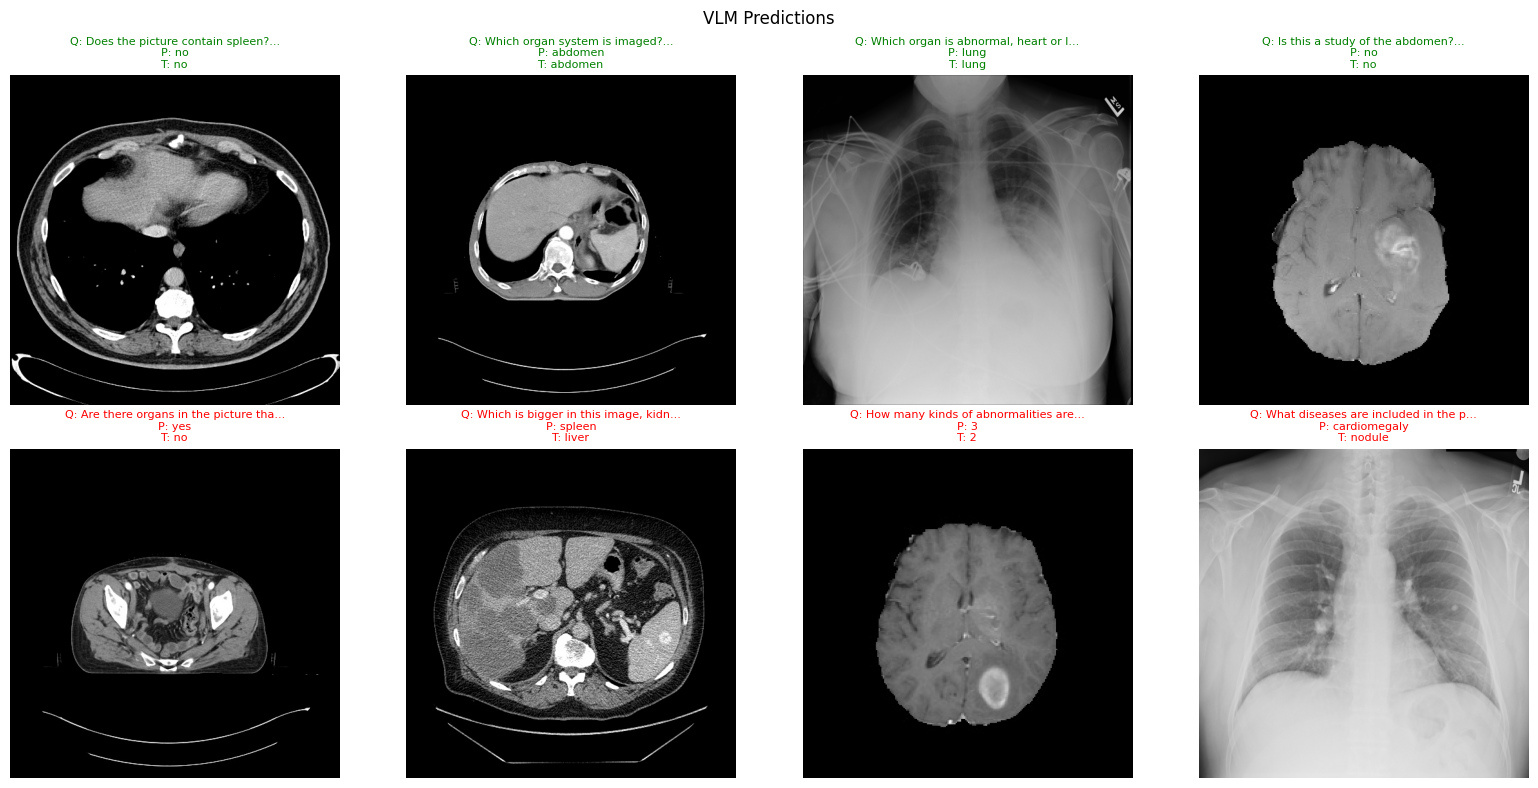

In [57]:
def show_preds(dataset, preds, labels, idx2answer, title, n=4):
    fig, axes = plt.subplots(2, n, figsize=(4*n, 8))

    # Correct: exact match OR flexible match
    correct = [i for i, (p, l) in enumerate(zip(preds, labels))
               if p == l or flexible_match(idx2answer.get(int(p), ''), idx2answer.get(int(l), ''))]

    # Wrong: NOT exact match AND NOT flexible match (TRUE errors only)
    wrong = [i for i, (p, l) in enumerate(zip(preds, labels))
             if p != l and not flexible_match(idx2answer.get(int(p), ''), idx2answer.get(int(l), ''))]

    for col, idx in enumerate(random.sample(correct, min(n, len(correct)))):
        item = dataset.data[idx]
        try:
            axes[0, col].imshow(Image.open(os.path.join(IMAGE_DIR, item['img_name'])).convert('RGB'))
        except: pass
        axes[0, col].set_title(f"Q: {item['question'][:35]}...\nP: {idx2answer.get(int(preds[idx]), '?')}\nT: {idx2answer.get(int(labels[idx]), '?')}", fontsize=8, color='green')
        axes[0, col].axis('off')

    for col, idx in enumerate(random.sample(wrong, min(n, len(wrong)))):
        item = dataset.data[idx]
        try:
            axes[1, col].imshow(Image.open(os.path.join(IMAGE_DIR, item['img_name'])).convert('RGB'))
        except: pass
        axes[1, col].set_title(f"Q: {item['question'][:35]}...\nP: {idx2answer.get(int(preds[idx]), '?')}\nT: {idx2answer.get(int(labels[idx]), '?')}", fontsize=8, color='red')
        axes[1, col].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, f'{title.lower().replace(" ", "_")}.png'), dpi=150)
    plt.show()

# Changed to VLM
show_preds(vlm_test_dataset, test_preds_vlm, test_labels_vlm, idx2answer, "VLM Predictions")

---

### 4. DISCUSSION

#### 4.1 Key Findings

**4.1.1 Domain Pretraining Advantage**
The BiomedCLIP-based VLM consistently outperformed the CNN-Transformer baseline across all evaluation metrics, achieving 86.15% flexible accuracy compared to 83.41%. This 2.74 percentage point improvement demonstrates that domain-specific pretraining on biomedical image-text pairs (PMC-15M) provides superior visual-semantic alignment compared to general-purpose ImageNet pretraining. Notably, this advantage was achieved with 18% fewer trainable parameters (149.7M vs 182.6M), indicating that the quality of pretrained representations matters more than model capacity for Med-VQA tasks.

**4.1.2 Ensemble Effectiveness**
The temperature-calibrated ensemble achieved the highest validation accuracy (86.23%) but failed to improve over the standalone VLM on test data (85.96% vs 86.15%). This counterintuitive result reveals that the two models share correlated error patterns—they tend to fail on the same intrinsically difficult samples rather than making complementary mistakes. This finding has important implications for ensemble design in medical AI: simply combining models with different architectures does not guarantee error diversity.

**4.1.3 Content-Specific Patterns**
Performance analysis by content type revealed distinct model strengths:
- **VLM excels at:** Shape recognition (+28.6%), color identification (+11.8%), quantity assessment (+11.5%), spatial position (+9.1%)
- **Baseline excels at:** Organ identification (−2.4% for VLM)

The VLM's advantages in semantically complex categories suggest that BiomedCLIP's contrastive pretraining captures richer conceptual representations. Conversely, the baseline's marginal advantage in organ identification indicates that ImageNet pretraining provides complementary inductive biases for fine-grained anatomical discrimination.

#### 4.2 Model Strengths and Weaknesses

| Aspect | CNN-Transformer Baseline | BiomedCLIP VLM |
|--------|-------------------------|----------------|
| **Strengths** | Stable training, lower hallucination risk, better organ ID | Higher accuracy, parameter efficient, semantic reasoning |
| **Weaknesses** | Limited capacity, plateaus early (~83%) | Wider train-val gap, overconfident predictions |
| **Best For** | Conservative predictions, anatomical tasks | Complex reasoning, semantic questions |

**4.2.1 Clinical Implications**
The clinical error analysis revealed that 39.5% of VLM errors carry high clinical impact:
- **Laterality confusion (18.4%):** Predicting "right lung" when answer is "left lung" — could lead to wrong-side interventions
- **Organ misidentification (16.3%):** Confusing anatomical structures — affects diagnostic focus
- **Condition assessment (4.8%):** Misclassifying pathological findings — direct diagnostic impact

These error patterns underscore that higher accuracy alone does not guarantee clinical safety. A system achieving 86% accuracy but making high-impact errors in 39.5% of its mistakes may pose greater risk than a more conservative system with predictable failure modes.

#### 4.3 Limitations

1. **Dataset Scope:** SLAKE contains 642 images across CT, MRI, and X-ray modalities. Performance may not generalize to other imaging types (ultrasound, PET) or specialized domains (ophthalmology, dermatology).

2. **Fixed-Answer Formulation:** The classification-based approach limits expressiveness for complex clinical queries requiring free-form responses.

3. **Single Dataset Evaluation:** Results on SLAKE may not transfer to other Med-VQA benchmarks (VQA-RAD, PathVQA) with different annotation styles.

4. **Hallucination Assessment:** While error analysis captures prediction mistakes, it does not directly measure hallucination rates or confidence calibration quality.

5. **Computational Constraints:** Experiments conducted on Google Colab (T4 GPU) limited hyperparameter search and model scaling exploration.

#### 4.4 Future Work

1. **Hallucination Mitigation:** Incorporate visual grounding mechanisms to ensure predictions are supported by image evidence

2. **Uncertainty Quantification:** Add confidence calibration and selective prediction (abstain when uncertain) for safer clinical deployment

3. **Multi-Dataset Validation:** Evaluate on VQA-RAD, PathVQA, and other benchmarks to assess generalization

4. **Generative Extension:** Explore controlled generation with medical ontology constraints for open-ended responses

5. **Human-in-the-Loop:** Integrate clinician feedback for high-impact predictions requiring verification

---

### 5. CONCLUSION

This study presents a comprehensive comparison of CNN-Transformer and BiomedCLIP-based Vision-Language Model architectures for Medical Visual Question Answering on the SLAKE dataset.

**Principal Findings:**

1. **Domain pretraining superiority:** The BiomedCLIP-based VLM achieved 86.15% flexible accuracy, outperforming the CNN-Transformer baseline (83.41%) by 2.74 percentage points while using 18% fewer parameters. This demonstrates that domain-specific multimodal pretraining is more effective than traditional CNN pipelines for Med-VQA.

2. **Ensemble limitations:** Temperature-calibrated ensemble methods failed to improve over the standalone VLM due to correlated error patterns between models, highlighting that architectural diversity alone does not guarantee complementary predictions.

3. **Clinical safety concerns:** Despite higher accuracy, 39.5% of VLM errors carry high clinical impact (laterality confusion, organ misidentification, condition assessment), necessitating mandatory human oversight for clinical deployment.

4. **Evaluation methodology:** Flexible accuracy metrics that account for semantic equivalence provide a more accurate assessment of model performance on open-ended medical questions, revealing that 2-3% of "errors" under strict matching are actually acceptable responses.

**Recommendations:**

- **For Research:** Report both strict and flexible accuracy metrics for comprehensive evaluation
- **For Development:** Prioritize domain-specific pretraining over model scaling
- **For Deployment:** Implement confidence thresholds and human verification for high-impact predictions

**Final Assessment:**
Vision-Language Models represent a significant advancement toward interactive medical image understanding, but the gap between benchmark accuracy and clinical reliability remains substantial. Future Med-VQA systems must balance improved performance with robust safety mechanisms, uncertainty quantification, and clinician-in-the-loop validation to achieve trustworthy clinical deployment.

---

### Summary Statistics

| Metric | Baseline | VLM | Ensemble |
|--------|----------|-----|----------|
| Strict Accuracy | 81.53% | 84.26% | 84.07% |
| Flexible Accuracy | 83.41% | 86.15% | 85.96% |
| True Error Rate | 16.59% | 13.85% | 14.04% |
| High-Impact Error % | — | 39.5% | — |
| Trainable Parameters | 182.6M | 149.7M | — |

**Best Model:** BiomedCLIP VLM (86.15% flexible accuracy)
**Clinical Readiness:** Requires human oversight due to high-impact error concentration